# Gaussian process regression trials - October 2022


to @Ellie: Best is if you go quickly through what I did in [A1](#A1) and then have a look into my questions inside of [A2](#A2)? 
- Do you know about any example code that does sth. similar as I want to do?
- What I would plan next is to translate my existing PyMC bayes calibration code (see pseudo-code in [A2](#A2)) into Pyro and then we can think about how we merge existing GPR emulator and that together!
    - before I start with that, it would be great if you can have a look if all this makes sense to you.

## ***Table of Contents:***

**[Option A: only use GPyTorch (together with Pyro)](#A)**

- **[A1: Use GPR only as emulator via GPyTorch Exact GP Model application](#A1)**
    - [A1.1: test workflow with the simplest exactGP regressor of GPyTorch](#A1.1) 
        - using workflow from https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Simple_GP_Regression.html
        - works so far (basically the same as what is done in PyGEM)
    - [A1.2: test workflow with the Bayesian GP regressor of GPyTorch](#A1.2)  
        - using workflow from https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/GP_Regression_Fully_Bayesian.html
        - works but a bit worse than A1.1

- **[A2: -todo- insert actual bayesian calibration with observed geodetic MB inside of GPytorch GPR](#A2)**
    - how do I do the "emulator creation" at the same point as the actual calibration where the "observed" geodetic MB is included?
        - and include there the geodetic observation uncertainties ? 
    - also include the correct parameter priors of temp_b & melt_f: at which step do I need to insert them?
        

**[Option B: only use PyMC](#B)**
- I also used once just PyMC (see: https://discourse.pymc.io/t/use-exact-gaussian-process-model-from-gpytorch-as-emulator-in-pymc3/8680/4, but I could not "merge" the two things together, i.e. emulator creation & actual MB model calibration using the observations) 

[Option C: NumPyro](#C)
   - Other idea: I could also use directly sth. like numpyro: https://num.pyro.ai/en/stable/examples/gp.html   


---

In [1]:
# everything that is needed for option A:

import numpy as np
import pandas as pd
#import torch
import matplotlib.pyplot as plt
import matplotlib
import os
import sklearn
import sklearn.model_selection
import gpytorch

## for Bayes GPR 
import pyro
from pyro.infer.mcmc import NUTS, MCMC, HMC
from gpytorch.priors import LogNormalPrior, NormalPrior, UniformPrior
## to visualize the distributions (works also with Pyro)
import arviz as az

%matplotlib inline

ModuleNotFoundError: No module named 'gpytorch'

In [2]:
# load specific MB mean for different MB model parameters (i.e. temp_b & melt_f, here done as a test for the Aletsch glacier): 
# choose the one with a fixed pf but variable temp. b and melt factors
pd_spec_mb = pd.read_csv('test_mb_RGI60-11.01450_fixed_pf_test.csv', index_col=[0])
# too many values make the notebook slow ... I just removed some parameters again ... 
pd_spec_mb = pd_spec_mb.sort_values(by=['melt_f', 'temp_bias']).iloc[1::3]
pd_spec_mb = pd_spec_mb.sort_values(by=['temp_bias','melt_f']).iloc[::2]
# applied MB model parameters that were used to estimated the real OGGM MB model (partly used for training the emulator)  
X = pd_spec_mb[['temp_bias','melt_f'] ].values 
# modelled specific mean MB (mean over 2000-2020) estimated from the real OGGM MB model (partly used for training the emulator) 
# we later want to match this value (i.e. y) with the geodetic observation 
y = pd_spec_mb['spec_mb_mean'].values

In [3]:
pd_spec_mb[['temp_bias','melt_f', 'spec_mb_mean']]  # this is how our training and testing data looks like

,temp_bias,melt_f,spec_mb_mean
99,-9.95,15.0,4447.609466
101,-9.95,35.0,4442.662098
103,-9.95,55.0,4437.714730
105,-9.95,75.0,4432.767362
107,-9.95,95.0,4427.819994
...,...,...,...
19791,9.85,915.0,-74043.378533
19793,9.85,935.0,-75693.041314
19795,9.85,955.0,-77342.704096
19797,9.85,975.0,-78992.366877


normalising data and separate training and testing data (I need that for every approach): 

In [4]:
random_state = 42 
### similar as what David Rounce does in PyGEM:

# normalize parameter data used inside "real" MB model (partly used for training the emulator) 
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

# normalize modelled MB data from "real" MB model (partly used for training the emulator) 
y_mean = y.mean()
y_std = y.std()
y_norm = (y - y_mean) / y_std

In [15]:
# Split into training and test data and cast to torch tensors
X_train,X_test,y_train,y_test = [torch.tensor(x).to(torch.float) 
                                 for x in sklearn.model_selection.train_test_split(X_norm,y_norm,  test_size=0.8,
                                                                                   random_state=random_state)]

# Add a small amount of noise
# Do I need that here, even if I will add later geodetic uncertainties into the GPR
y_train += torch.randn(*y_train.shape)*0.01

# need to optimize the size of train and test data later and think about 
# how I select the parameters that are used to "calibrate the emulator"
np.shape(X_train), np.shape(y_train), np.shape(X_test), np.shape(y_test)

NameError: name 'torch' is not defined

# Option A: only use GPyTorch (together with Pyro):<a id='A'></a>

## A1: Use GPR only as emulator via GPyTorch Exact GP Model application <a id='A1'></a>

In [12]:
# need that for both A1.1 and A1.2
class ExactGPModel(gpytorch.models.ExactGP):
    """ Use the simplest form of GP model, exact inference 
    copied from https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html
    """
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)) #3 if pf, temp. b and melt factor

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### A1.1: test workflow with the simplest exactGP regressor of GPyTorch<a id='A1.1'></a>

**from here, I basically do what is done in PyGEM:**

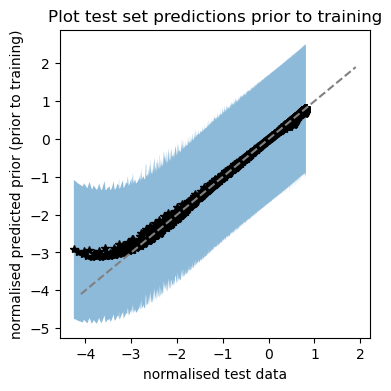

In [13]:
# basically copied from PyGEM and adapted slightly
# initialize likelihood and model
# likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood = gpytorch.likelihoods.GaussianLikelihood() #noise_prior=gpytorch.priors.SmoothedBoxPrior(0.15, 1.5, sigma=0.001))
model = ExactGPModel(X_train, y_train, likelihood)


# Plot test set predictions prior to training
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()
with torch.no_grad():#, gpytorch.settings.fast_pred_var():
    y_pred = likelihood(model(X_test))
idx = np.argsort(y_test.numpy())

with torch.no_grad():
    lower, upper = y_pred.confidence_region()

    f, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.set_title('Plot test set predictions prior to training')
    ax.plot(y_test.numpy()[idx], y_pred.mean.numpy()[idx], 'k*')
    ax.fill_between(y_test.numpy()[idx],
                    lower.numpy()[idx],
                    upper.numpy()[idx], alpha=0.5)
    ax.plot(np.arange(-4.1,2.2,0.5), np.arange(-4.1,2.2,0.5), ls='--', color='grey')
    plt.xlabel('normalised test data')
    plt.ylabel('normalised predicted prior (prior to training)')
    plt.show()


- the prior underestimates the actual MB for small values (why is this the case?). In any case it does not matter, because this is not yet "calibrated" anyways !!!

- small problems that I solved by changing e.g. learning rate:
    - CG Terminated in 1000 iterations with average residual norm ... which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance : 
        - https://github.com/cornellius-gp/gpytorch/issues/1297 (add `noise_prior=gpytorch.priors.SmoothedBoxPrior(0.15, 1.5, sigma=0.001` into likelihood ... )
        - https://github.com/cornellius-gp/gpytorch/issues/1129 (or decrease learning rate)
            - now it works, but need to check what that means ...

Next step:
- .train() mode is for optimizing model hyperameters
- .eval() mode is for computing predictions through the model posterior

In [14]:
### how do I choose the right model hyperparameters ???
# ----- Find optimal model hyperparameters -----

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.3)  # Includes GaussianLikelihood parameters


# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(1000):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train)
    loss.backward()
    if i%100==0:
         print(i, loss.item(), model.covar_module.base_kernel.lengthscale[0], 
                  model.likelihood.noise.item())
    optimizer.step()
# sometimes I get a NotPSDError: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. error
# don't know why -> but then I just reload the training/testing dataset and it works again ...

0 0.8090977072715759 tensor([0.6931, 0.6931], grad_fn=<SelectBackward0>) 0.6932471990585327
100 -2.971916675567627 tensor([1.5283, 5.6266], grad_fn=<SelectBackward0>) 0.00011161107249790803
200 -2.9819509983062744 tensor([1.7168, 5.8821], grad_fn=<SelectBackward0>) 0.000134569316287525
300 -2.9298906326293945 tensor([1.9265, 5.8026], grad_fn=<SelectBackward0>) 0.00018643378280103207
400 -2.913459539413452 tensor([1.8900, 6.8884], grad_fn=<SelectBackward0>) 0.00018695546896196902
500 -2.9010443687438965 tensor([1.9974, 6.5872], grad_fn=<SelectBackward0>) 0.00021387494052760303
600 -2.8787877559661865 tensor([1.8230, 6.8702], grad_fn=<SelectBackward0>) 0.000245977018494159
700 -1.8683301210403442 tensor([3.3196, 5.9906], grad_fn=<SelectBackward0>) 0.003018931718543172
800 -2.8830678462982178 tensor([1.9358, 7.0535], grad_fn=<SelectBackward0>) 0.00012649250857066363
900 -2.894124984741211 tensor([1.9881, 7.1304], grad_fn=<SelectBackward0>) 0.00011674767301883548


**Plot posterior distributions (with test data on x-axis) - Get into evaluation (predictive posterior) mode**

normalised mean absolute error: 0.0055
normalised rmse: 0.0067
R2-score: 1.0


/tmp/ipykernel_87736/3219708577.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_em_norm_test = model(torch.tensor(X_test).to(torch.float)).mean.detach().numpy()
/home/lilianschuster/anaconda3/envs/pymc_env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/lilianschuster/anaconda3/envs/pymc_env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/lilianschuster/anaconda3/envs/pymc_env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


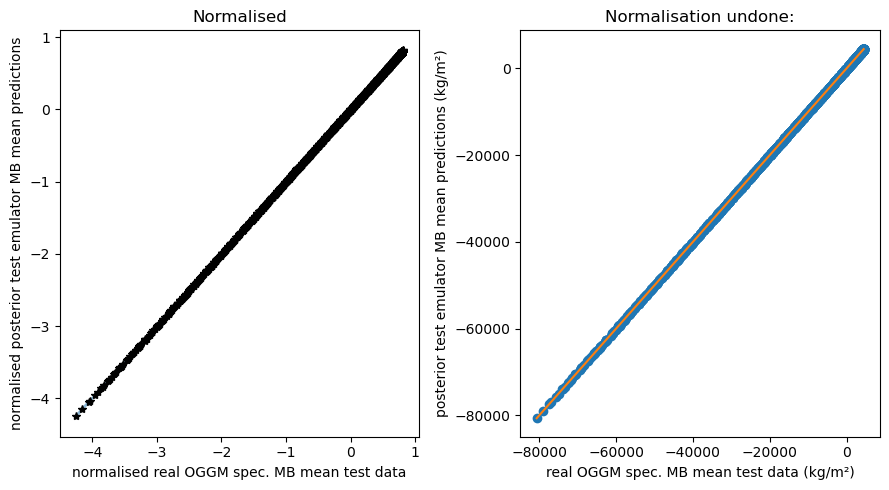

In [15]:
model.eval()
likelihood.eval()
with torch.no_grad():
    y_pred = likelihood(model(X_test))

idx = np.argsort(y_test.numpy())

with torch.no_grad():
    lower, upper = y_pred.confidence_region()

    f, axs = plt.subplots(1, 2, figsize=(9, 5))
    # Compare the modeled and emulated "test" mass balances (WITH normalisation)
    ax = axs[0]
    ax.set_title('Normalised')
    ax.plot(y_test.numpy()[idx], y_pred.mean.numpy()[idx], 'k*')
    mae_norm = sklearn.metrics.mean_absolute_error(y_test.numpy()[idx],y_pred.mean.numpy()[idx])
    rmse_norm = sklearn.metrics.mean_squared_error(y_test.numpy()[idx],y_pred.mean.numpy()[idx], 
                                                   squared = False)  # returns rmse error!!!
    print(f'normalised mean absolute error: {mae_norm:.2}')
    print(f'normalised rmse: {rmse_norm:.2}')

    ax.fill_between(y_test.numpy()[idx], lower.numpy()[idx], upper.numpy()[idx], 
                    alpha=0.5)
    ax.set_xlabel('normalised real OGGM spec. MB mean test data')
    ax.set_ylabel('normalised posterior test emulator MB mean predictions')

    # Compare the modeled and emulated "test" mass balances (WITHOUT normalisation)
    ax = axs[1]
    ax.set_title('Normalisation undone:')
    y_em_norm_test = model(torch.tensor(X_test).to(torch.float)).mean.detach().numpy()
    y_em_test_nonnorm = y_em_norm_test * y_std + y_mean
    y_test_nonnorm = y_test * y_std + y_mean

    ax.plot(y_test_nonnorm, y_em_test_nonnorm, 'o')
    ax.plot([y.min(),y.max()], [y.min(), y.max()])
    ax.set_ylabel('posterior test emulator MB mean predictions (kg/m²)')
    ax.set_xlabel('real OGGM spec. MB mean test data (kg/m²)')

    r2_test_data = sklearn.metrics.r2_score(y_test_nonnorm, y_em_test_nonnorm)
    print(f'R2-score: {r2_test_data:.2}')

    plt.tight_layout()
    plt.show()


- this plot basically shows that the emulator reproduces the MB (checked by test data that was not used for the emulator calibration)
    - which kind of test should I use there, maybe just checking that normalised mae < ..., rmse < ... & that R2 almost 1 ???
    - which thresholds are ok, how much train / test data should I use?

In [16]:
# possible thresholds that might be checked later automatically...
np.testing.assert_allclose(r2_test_data, 1, rtol=1e-3)
np.testing.assert_allclose(mae_norm, 0, atol=1e-2)
np.testing.assert_allclose(rmse_norm, 0, atol=1e-2)



**More diagnostic plots**

/home/lilianschuster/anaconda3/envs/pymc_env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/lilianschuster/anaconda3/envs/pymc_env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/lilianschuster/anaconda3/envs/pymc_env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


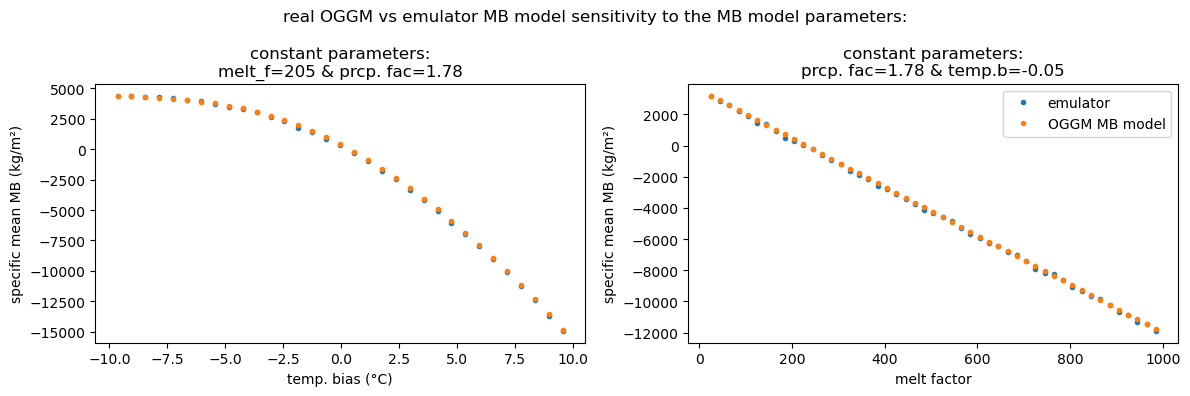

In [17]:
# Compare user-defined parameter sets within the emulator
# here just change tbias and the other things are kept cte for the moment
tb_sel = -0.05
pf_sel = pd_spec_mb.prcp_fac.unique().round(2)[0]
melt_f_sel = 205
f, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.suptitle('real OGGM vs emulator MB model sensitivity to the MB model parameters:')
for j,tip in enumerate(['tb_var', 'melt_f_var']): #pf_var
    ax = axs[j]
    #if tip == 'pf_var':
    #    pd_spec_mb_sel = pd_spec_mb[pd_spec_mb.temp_bias == tb_sel].copy()
    #    pd_spec_mb_sel = pd_spec_mb_sel[pd_spec_mb_sel.melt_f == melt_f_sel]
    if tip == 'tb_var':
        #pd_spec_mb_sel = pd_spec_mb[pd_spec_mb.prcp_fac == pf_sel].copy()
        pd_spec_mb_sel = pd_spec_mb[pd_spec_mb.melt_f == melt_f_sel]
    elif tip == 'melt_f_var':
        #pd_spec_mb_sel = pd_spec_mb[pd_spec_mb.prcp_fac == pf_sel].copy()
        pd_spec_mb_sel = pd_spec_mb[pd_spec_mb.temp_bias.round(2) == tb_sel]
    tbias_set =  pd_spec_mb_sel.temp_bias.values.reshape(-1,1) #(np.arange(-7,4,0.5)).reshape(-1,1)
    prcp_fac_set = pd_spec_mb_sel.prcp_fac.values.reshape(-1,1) #.np.zeros(tbias_set.shape) + 1
    melt_f_set = pd_spec_mb_sel.melt_f.values.reshape(-1,1) #. np.zeros(tbias_set.shape) + 0.0041

    #modelprms_set = np.hstack((tbias_set, prcp_fac_set, melt_f_set))
    modelprms_set = np.hstack((tbias_set, melt_f_set))
    modelprms_set_norm = (modelprms_set - X_mean) / X_std

    y_set_norm = model(torch.tensor(modelprms_set_norm).to(torch.float)).mean.detach().numpy()
    y_set = y_set_norm * y_std + y_mean

    if tip == 'pf_var':
        ax.plot(prcp_fac_set, y_set,'.', label ='emulator')
        ax.set_xlabel('prcp. fac')
        ax.plot(pd_spec_mb_sel.prcp_fac, pd_spec_mb_sel.spec_mb_mean, '.',
                label='OGGM MB model')
        ax.set_title(f'constant parameters:\nmelt_f={melt_f_sel} & temp. b={tb_sel}')
    elif tip == 'tb_var':
        ax.plot(tbias_set, y_set,'.', label ='emulator')
        ax.set_xlabel('temp. bias (°C)')
        ax.plot(pd_spec_mb_sel.temp_bias, pd_spec_mb_sel.spec_mb_mean, '.',
                label='OGGM MB model')
        ax.set_title(f'constant parameters:\nmelt_f={melt_f_sel} & prcp. fac={pf_sel}')

    elif tip == 'melt_f_var':
        ax.plot(melt_f_set, y_set,'.', label ='emulator')
        ax.set_xlabel('melt factor')
        ax.plot(pd_spec_mb_sel.melt_f, pd_spec_mb_sel.spec_mb_mean, '.',
                label='OGGM MB model')
        ax.set_title(f'constant parameters:\nprcp. fac={pf_sel} & temp.b={tb_sel}')


    ax.set_ylabel('specific mean MB (kg/m²)')


    plt.legend()
    plt.tight_layout()
#kp_1_idx = np.where(sims_df['kp'] == 1)[0]
#ax.plot(sims_df.loc[kp_1_idx,'tbias'], sims_df.loc[kp_1_idx,y_cn])

#ax.set_ylabel('OGGM MB (mwea)')
#if y_cn == 'mb_mwea':
#    ax.set_ylabel('PyGEM MB (mwea)')
#elif y_cn == 'nbinyrs_negmbclim':
#    ax.set_ylabel('nbinyrs_negmbclim (-)')

### A1.2: test workflow with the Bayesian GP regressor of GPyTorch <a id='A1.2'></a>


#### trial to follow GP_Regression_Fully_Bayesian (without including priors & geodetic calibration for the moment):
- https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/GP_Regression_Fully_Bayesian.html
- **From GyPyTorch Docs**: 
>The high level overview of sampling in GPyTorch is as follows: 
    > Define your model as normal, extending ExactGP and defining a forward method.
    
    >For each parameter your model defines, you’ll need to register a GPyTorch prior with that parameter, or some function of the parameter. If you use something other than a default closure (e.g., by specifying a parameter or transformed parameter name), you’ll need to also specify a setting_closure: see the docs for gpytorch.Module.register_prior.

    >Define a pyro model that has a sample site for each GP parameter. For your convenience, we define a pyro_sample_from_prior method on gpytorch.Module that returns a copy of the module where each parameter has been replaced by the result of a pyro.sample call.

    >Run NUTS (or HMC etc) on the pyro model you just defined to generate samples. Note this can take quite a while or no time at all depending on the priors you’ve defined.

    >Load the samples in to the model, converting the model from a simple GP to a batch GP (see our example notebook on simple batch GPs), where each GP in the batch corresponds to a different hyperparameter sample.

    >Pass test data through the batch GP to get predictions for each hyperparameter sample.


In [18]:
smoke_test = ('CI' in os.environ)
num_samples = 2 if smoke_test else 100 #100
warmup_steps = 2 if smoke_test else 100


# Use a positive constraint instead of usual GreaterThan(1e-4) so that LogNormal has support over full range.
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Positive())
model = ExactGPModel(X_train, y_train, likelihood)

### maybe I need to register somewhere here also the MB model parameter priors (in a normalised way) from temp. b & melt_f ???  
# maybe it is the "lengthscale_prior" for the params & the "outputscale_prior" for the geodetic observations???
# sth. like .. pyro.sample("mu", dist.Normal(0, 5))
model.mean_module.register_prior("mean_prior", UniformPrior(-1, 1), "constant")     
model.covar_module.base_kernel.register_prior("lengthscale_prior", UniformPrior(0.01, 0.5), "lengthscale")
model.covar_module.register_prior("outputscale_prior", UniformPrior(1, 2), "outputscale")
likelihood.register_prior("noise_prior", UniformPrior(0.01, 0.5), "noise")


mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def pyro_model(x, y):
    with gpytorch.settings.fast_computations(False, False, False):
        sampled_model = model.pyro_sample_from_prior()
        output = sampled_model.likelihood(sampled_model(x)) 
        pyro.sample("obs", output, obs=y) 
        # here I normally need to add somewhere the geodetic uncertainties and the actual geodetic observation? 
        # should I just add here another sampling 
    return y

nuts_kernel = NUTS(pyro_model)
mcmc_run = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps, disable_progbar=smoke_test)
mcmc_run.run(X_train, y_train)
# after that, dimension of model.train_inputs[0] : torch.Size([520, 2])
# # when running this -> creates a new dimension , like samples from trained inputs ... 
model.pyro_load_from_samples(mcmc_run.get_samples())  
# then: ([100, 520, 2])

Sample: 100%|██| 200/200 [00:32,  6.22it/s, step size=3.94e-01, acc. prob=0.689]


In [19]:
model.eval()
likelihood.eval()
# num_samples necessary to have the right format, 
# the additional sample dimension comes inside when doing model.pyro_load_from_samples(mcmc_run.get_samples())
y_pred = likelihood(model(X_test.unsqueeze(0).repeat(num_samples, 1, 1)))


/home/lilianschuster/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


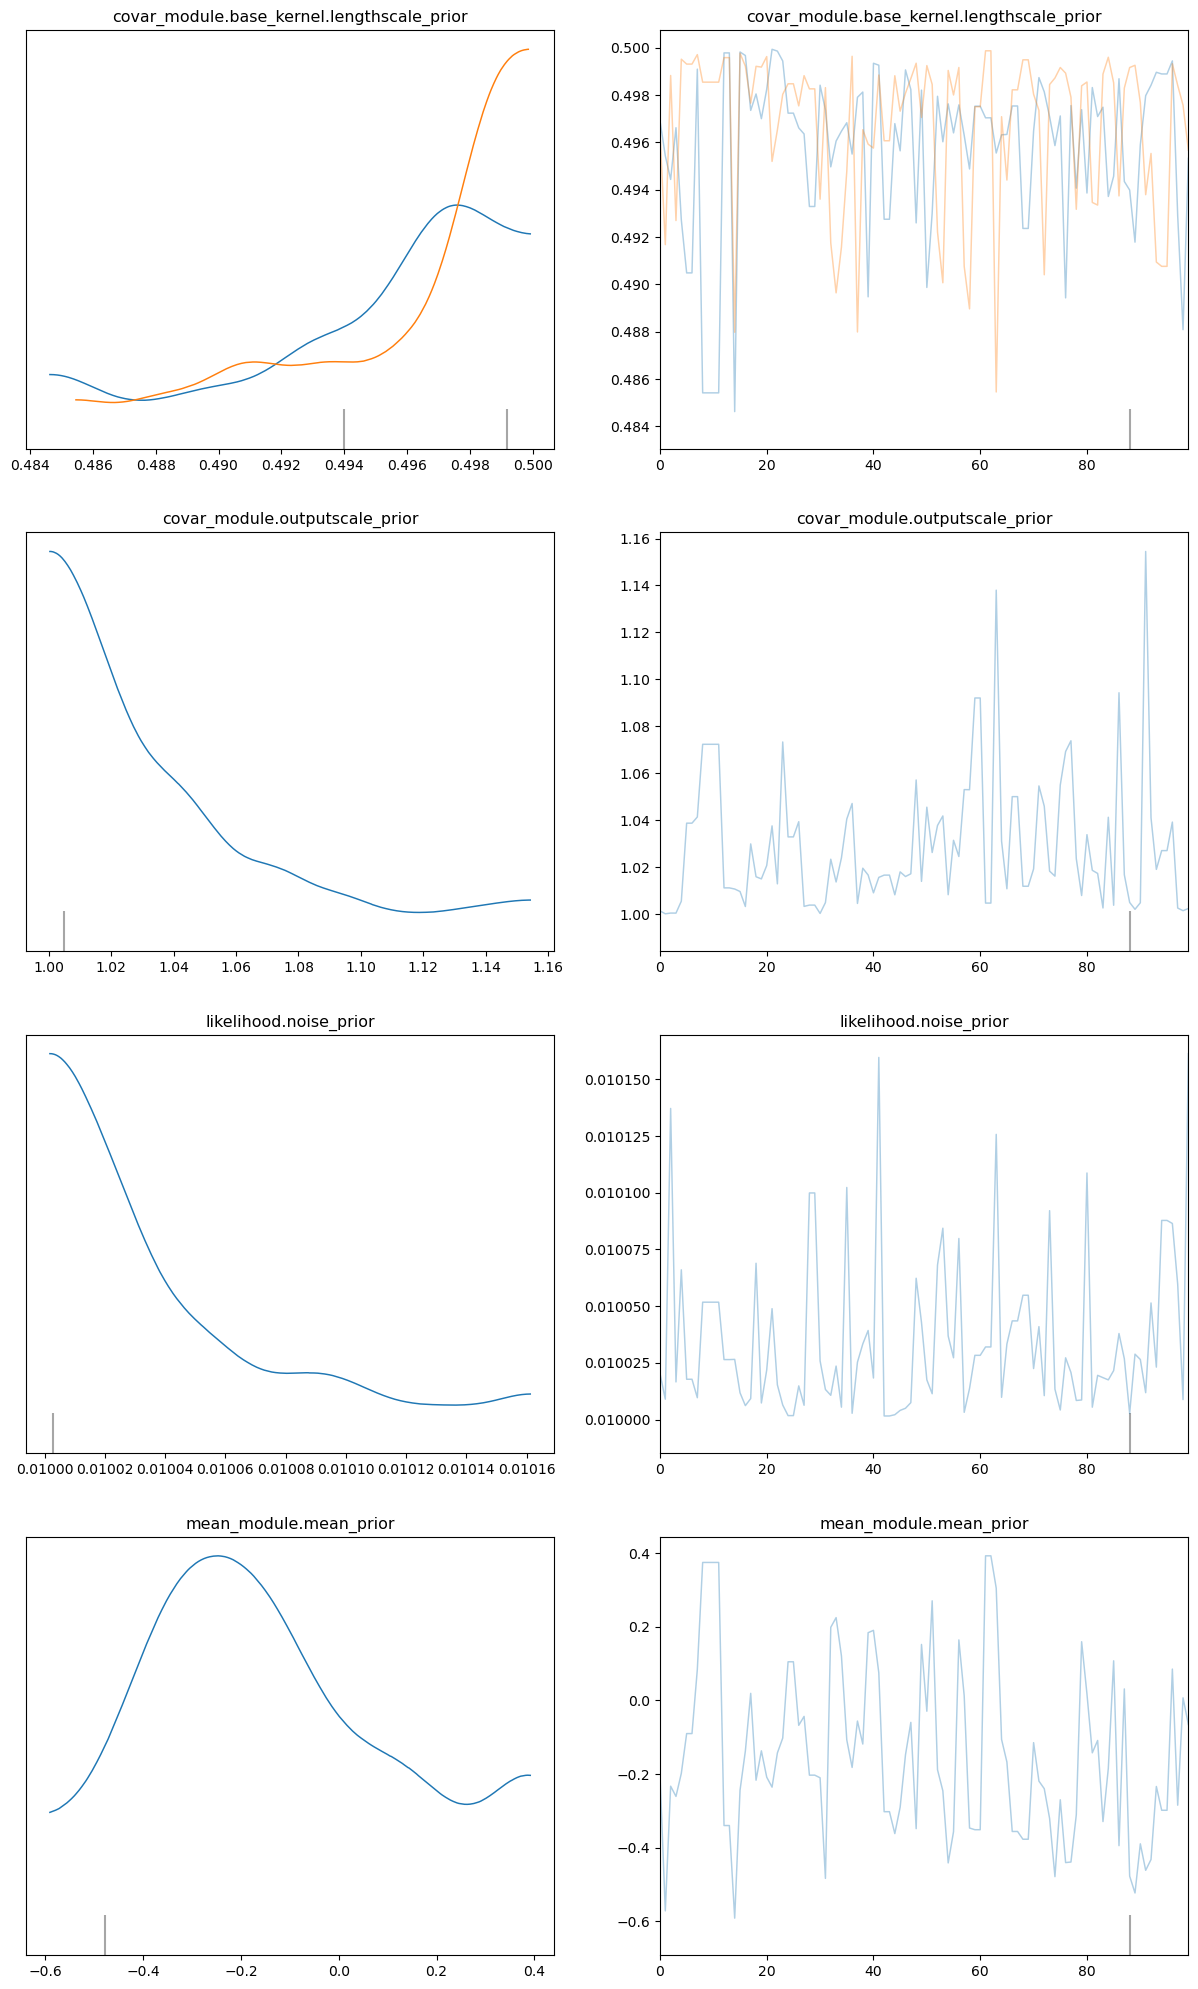

In [20]:
### can export output to arviz and plot stuff if I want to
### but of course here I only see the GP priors
az_mcmc_run = az.from_pyro(mcmc_run)
az.plot_trace(az_mcmc_run, compact=True, figsize=(15, 25));

normalised mean absolute error: 0.0052
normalised rmse: 0.012


/tmp/ipykernel_87736/3681228851.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_em_norm_test = model(torch.tensor(X_test).to(torch.float)).mean[i].detach().numpy()


R2-score: 1.0


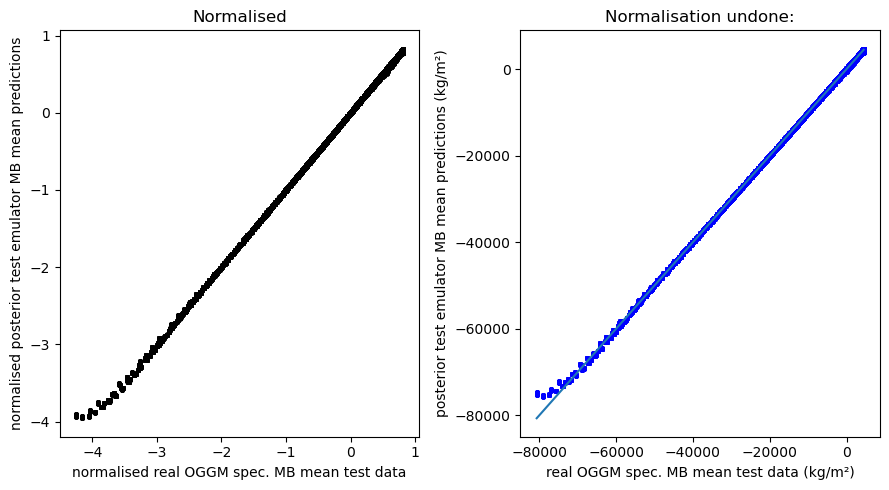

In [22]:
idx = np.argsort(y_test.numpy())

with torch.no_grad():
    lower, upper = y_pred.confidence_region()

    f, axs = plt.subplots(1, 2, figsize=(9, 5))
    # Compare the modeled and emulated "test" mass balances (WITH normalisation)
    ax = axs[0]
    ax.set_title('Normalised')
    mae_norm_l = []
    rmse_norm_l = []
    for i in range(min(num_samples, 25)):
        y_pred_mean = y_pred.mean[i].detach().numpy()[idx]
        ax.plot(y_test.numpy()[idx], y_pred_mean, 'k.', ms=5)
        mae_norm_l.append(sklearn.metrics.mean_absolute_error(y_test.numpy()[idx], y_pred_mean))
        rmse_norm_l.append(sklearn.metrics.mean_squared_error(y_test.numpy()[idx], y_pred_mean, 
                                                       squared = False))  # returns rmse error!!!
    print(f'normalised mean absolute error: {np.array(mae_norm_l).mean():.2}')
    print(f'normalised rmse: {np.array(rmse_norm_l).mean():.2}')


    ax.set_xlabel('normalised real OGGM spec. MB mean test data')
    ax.set_ylabel('normalised posterior test emulator MB mean predictions')

    # Compare the modeled and emulated "test" mass balances (WITHOUT normalisation)
    ax = axs[1]
    ax.set_title('Normalisation undone:')
    for i in range(min(num_samples, 25)):
        y_em_norm_test = model(torch.tensor(X_test).to(torch.float)).mean[i].detach().numpy()
        y_em_test_nonnorm = y_em_norm_test * y_std + y_mean
        y_test_nonnorm = y_test * y_std + y_mean

        ax.plot(y_test_nonnorm.numpy()[idx], y_em_test_nonnorm[idx], 'b.', ms=5)
    ax.plot([y.min(),y.max()], [y.min(), y.max()])
    ax.set_ylabel('posterior test emulator MB mean predictions (kg/m²)')
    ax.set_xlabel('real OGGM spec. MB mean test data (kg/m²)')

    r2_test_data = sklearn.metrics.r2_score(y_test_nonnorm, y_em_test_nonnorm)
    print(f'R2-score: {r2_test_data:.2}')

    plt.tight_layout()
    plt.show()


- I somehow repeated what I did with the most simple exact GP now with the Bayesian version. It works a bit less good (i.e. mae and rmse are larger), but It should be still accurate enough ...  
    - more influence from Kernel prior (use e.g. linear Kernel)

## A2: -todo- insert actual bayesian calibration with observed geodetic MB inside of GPytorch GPR<a id='A2'></a>

In [24]:
# use GPyTorch and Pyro 
# steps: 
## use adapted GPR from A1.2 (or A1.1)

## translate bayes calibration part from PyMC to Pyro (see pseudo-code below)

## -> the difficult part I think: get them together !!!


Aim:
- create emulator and do the calibration w. prior & geodetic uncertainty description at once
   - Can I use for that the approach as in [A1.2](#A1.2) (i.e. https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/GP_Regression_Fully_Bayesian.html ) and extend that approach to include the missing parts?
       - **... how / where to include now the missing parts inside of the Bayesian GPR (geodetic calibration w. priors & geodetic uncertainties) ???**
   - Or should I first run the exact GP with the loss function as in [A1.1](#A1.1) and then use the model.evaluate function to run the bayes calibration using the Pyro language???
   - there is a notebook on GPyTorch with GP regression on uncertain inputs 
       --> **GP Regression with Uncertain Inputs** but this is I think not what we need
        - https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/GP_Regression_DistributionalKernel.html#GP-Regression-with-Uncertain-Inputs



***Some dummy test data:***

In [25]:
# priors:
## temp_b : TruncatedNormal
temp_b_mean = 0
temp_b_std = 2
temp_b_lower_limit = -8
temp_b_upper_limit = 8

## melt_f : TruncatedNormal
melt_f_mean = 250
melt_f_std = 100
melt_f_lower_limit = 10
melt_f_upper_limit = 1000

# MB model or emulator
## from OGGM ...
## modelled_mb = get_spec_avg_mb(melt_f, temp_b)
    # not compatible with pymc aesara
    # def get_spec_avg_mb(melt_f,t_b):
    #    mb_mod = ...    ### comes from OGGM 
    #    mb_mod.mu_star = melt_f
    #    mb_mod.temp_bias = t_b
    #    spec_mb = mb_mod.get_specific_mb(heights=hgts, widths=widths,
    #                                     year=np.arange(2000, 2020, 1))
    #    return np.array(spec_mb.mean())
## OR from the GPR emulator that is trained with data from OGGM
## modelled_mb = GPR(melt_f, temp_b) see-> A1.1 or A1.2

# observed MB
## to which the MB parameters (temp_b, melt_f) of the MB model should be calibrated to 
obs_mean_aletsch = -1210  # geodetic observation to what we want to calibrate
obs_sigma_aletsch = 171  # std of geodetic observations

# max. of specific MB until actually entire glacier melts away 
# i.e. we don't want to allow MB parameters which go below this threshold
max_allowed_specificMB = -100000  # just a dummy value here

**-> below is a pseudo-code in PyMC language for the Bayesian calibration which needs to be translated into Pyro?!**

- it does not run in PyMC (as I can't put the emulator inside, but it shows how the bayesian calibration should look like)

In [ ]:
##### pseudo - code : this does not run ! ##################
# --> needs to be translated into the Pyro language 
with pm.Model() as model: 
    # std. of geodetic observations 
    #(only works because I have only one observation!!!)
    # otherwise need intrinsic scatter of model fit (recommended 
    # statistically)  -> pm.HalfNormal("sigma", sd=5)  
    sigma = pm.Data('sigma', [obs_sigma_aletsch])  
    
    # Define priors
    t_b = pm.TruncatedNormal('t_b', mu=temp_b_mean,
                             sigma=temp_b_std,
                             lower=temp_b_lower_limit,
                             upper=temp_b_upper_limit)
    melt_f = pm.TruncatedNormal('melt_f',
                                mu=melt_f_mean,
                                sigma=melt_f_std,
                                lower=melt_f_lower_limit,
                                upper=melt_f_upper_limit)
    
    # model fit
    # (here avg. modelled MB)
    # get_spec_avg_mb could be replaced by the emulator tfrom A.1 ... i.e.
    # mu= GPR(melt_f, t_b) OR 
    mu = get_spec_avg_mb(melt_f, t_b)

    # observations (to which we want to calibrate "get_spec_avg_mb" or "GPR")
    observed = pm.Data('observed', [obs_mean_aletsch]) # here for Aletsch glacier
    
    # minimum MB constraint
    max_allowed_specificMB_pm = pm.Data('max_allowed_specificMB',
                                        [max_allowed_specificMB])

    # sample priors to later look at them 
    prior = pm.sample_prior_predictive(random_seed=random_seed, #cores=cores,
                                       samples=1000)  # , keep_size = True)
    
    # Fit likelihood * prior
    posterior = pm.TruncatedNormal("posterior", 
                                   mu = mu,
                                   #mu = mu,
                                   sigma=sigma,
                                   observed=observed, 
                                   lower = max_allowed_specificMB)
    
    # Inference!
    trace = pm.sample(5000, cores=3, return_inferencedata=True)

    # already 1000 per chain burnt
    ppc = pm.sample_posterior_predictive(trace, 
                                         random_seed=random_seed,
                                         var_names=['posterior',
                                                    't_b', 'melt_f'],
                                         keep_size=True)

Here are some links that might help us to translate the pseudo-code into Pyro: 
   - incorporate GP as part of larger probabilistic models: 
       - https://docs.gpytorch.ai/en/stable/examples/07_Pyro_Integration/index.html
   - GPyTorch prior docs: https://docs.gpytorch.ai/en/stable/priors.html#prior
   - Pyro Bayesian regression: http://pyro.ai/examples/bayesian_regression.html
   - there is also a different direct implementation of GP inside of Pyro
       - http://pyro.ai/examples/gp.html
       - not sure what is best?! 
   - or use directly NumPyro -> https://num.pyro.ai/en/stable/examples/gp.html

# Option B: Use PyMC for GPR and calibration<a id='B'></a>

I left this here inside just in case we do not manage to use GPyTorch with Pyro. In that case, we could still try to do all in PyMC (although I did not manage to do that). So far, I just have a bayesian GPR emulator in PyMC and the bayesian calibration, but can't put them together. 

Some links to GPR inside of PyMC:
- https://pymc-learn.readthedocs.io/en/latest/_modules/pmlearn/gaussian_process/gpr.html#GaussianProcessRegressor
--> actually I tried to use https://johngoertz.github.io/Gumbi/  to do that, but how do I go on from there? How to include the priors and geodetic uncertainties  / observation to also driectly calibrate on that???
- instead tried pure PyMC again, see code below, but encountered an issue that I described here:
    -> https://discourse.pymc.io/t/use-exact-gaussian-process-model-from-gpytorch-as-emulator-in-pymc3/8680/4
- example code where it seems to work -> but I did not understand it: 
    - https://colab.research.google.com/drive/1PF3ni-8zU4nYCcP2UPW1aK9kDSHNM7Tm?usp=sharing#scrollTo=UKG7my7stPdh

In [5]:
# I import pymc just here because we don't need it before ...
import pymc as pm

In [6]:
# Split into training and test data (but witout having torch tensors ... )
X_train_pm,X_test_pm,y_train_pm,y_test_pm = sklearn.model_selection.train_test_split(X_norm,y_norm, test_size=0.8)

GPR emulator in PyMC -> probably similar to what is done in the [bayesian GPytorch approach of A1.2](#A1.2)


In [7]:
# I did not at all think about the GP priors here, so a lot of improvements can be done here to make the code faster / more efficient
with pm.Model() as model_reg:
    # hyperprior for lengthscale kernel parameter ℓ = pm.Gamma('ℓ', 2, 0.5)
    l = pm.Gamma('l', alpha=2, beta=0.5) # 0.5 goes faster
    # instantiate a covariance function 
    input_dim = 2 #3
    cov = pm.gp.cov.ExpQuad(input_dim, ls=l)
    #cov = pm.gp.cov.Linear(input_dim, ls=l)

    # instantiate a GP prior 
    gp = pm.gp.Marginal(cov_func=cov)
    # prior
    epsilon = pm.HalfNormal('epsilon', 0.001) #10)
    # likelihood 
    y_pred = gp.marginal_likelihood('y_pred', X=X_train_pm, y=y_train_pm, noise=epsilon)
    # mp = pm.find_MAP(include_transformed=True)
    
    trace_reg = pm.sample(500, return_inferencedata=True, cores=1, chains = 2)

/home/lilianschuster/micromamba/envs/oggm_pymc/lib/python3.9/site-packages/pymc/gp/gp.py:54: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
WARNING (aesara.link.c.cmodule): Deleting (Broken cache directory [EOF]): /home/lilianschuster/.aesara/compiledir_Linux-5.4--generic-x86_64-with-glibc2.31-x86_64-3.9.13-64/tmp1zwqeig9
WARNING (aesara.link.c.cmodule): Deleting (Broken cache directory [EOF]): /home/lilianschuster/.aesara/compiledir_Linux-5.4--generic-x86_64-with-glibc2.31-x86_64-3.9.13-64/tmp2w61ig81
WARNING (aesara.link.c.cmodule): Deleting (Broken cache directory [EOF]): /home/lilianschuster/.aesara/compiledir_Linux-5.4--generic-x86_64-with-glibc2.31-x86_64-3.9.13-64/tmp3mea3gdm
WARNING (aesara.link.c.cmodule): Deleting (Broken cache directory [EOF]): /home/lilianschuster/.aesara/compiledir_Linux-5.4--generic-x86_64-with-gli

ImportError: /home/lilianschuster/.aesara/compiledir_Linux-5.4--generic-x86_64-with-glibc2.31-x86_64-3.9.13-64/tmp_nu45lag/mc2a89b4385f15a1e17a2f26f9ef7a9d9adb8bb34da9f0db85e7aa1449093b647.so: file too short
Apply node that caused the error: Elemwise{eq,no_inplace}(l_log___log, TensorConstant{0})
Toposort index: 6
Inputs types: [TensorType(float64, ()), TensorType(int8, ())]

Backtrace when the node is created (use Aesara flag traceback__limit=N to make it longer):
  File "/home/lilianschuster/micromamba/envs/oggm_pymc/lib/python3.9/site-packages/pymc/model.py", line 758, in logp
    rv_logps = joint_logp(list(rv_values.keys()), rv_values, sum=False, jacobian=jacobian)
  File "/home/lilianschuster/micromamba/envs/oggm_pymc/lib/python3.9/site-packages/pymc/distributions/logprob.py", line 237, in joint_logp
    temp_logp_var_dict = factorized_joint_logprob(
  File "/home/lilianschuster/micromamba/envs/oggm_pymc/lib/python3.9/site-packages/aeppl/joint_logprob.py", line 151, in factorized_joint_logprob
    q_logprob_vars = _logprob(
  File "/home/lilianschuster/micromamba/envs/oggm_pymc/lib/python3.9/functools.py", line 888, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/home/lilianschuster/micromamba/envs/oggm_pymc/lib/python3.9/site-packages/aeppl/transforms.py", line 611, in transformed_logprob
    logprob = _logprob(rv_op, values, *inputs, **kwargs)
  File "/home/lilianschuster/micromamba/envs/oggm_pymc/lib/python3.9/functools.py", line 888, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/home/lilianschuster/micromamba/envs/oggm_pymc/lib/python3.9/site-packages/aeppl/logprob.py", line 298, in gamma_logprob
    + xlogy0(alpha - 1, value)
  File "/home/lilianschuster/micromamba/envs/oggm_pymc/lib/python3.9/site-packages/aeppl/logprob.py", line 50, in xlogy0
    return at.switch(at.eq(x, 0), at.switch(at.eq(m, 0), 0.0, -np.inf), m * at.log(x))

HINT: Use a linker other than the C linker to print the inputs' shapes and strides.
HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [49]:
point = {'l': trace_reg.posterior['l'].mean(), 'epsilon': trace_reg.posterior['epsilon'].mean()}

array([[<AxesSubplot: title={'center': 'l'}>,
        <AxesSubplot: title={'center': 'l'}>],
       [<AxesSubplot: title={'center': 'epsilon'}>,
        <AxesSubplot: title={'center': 'epsilon'}>]], dtype=object)

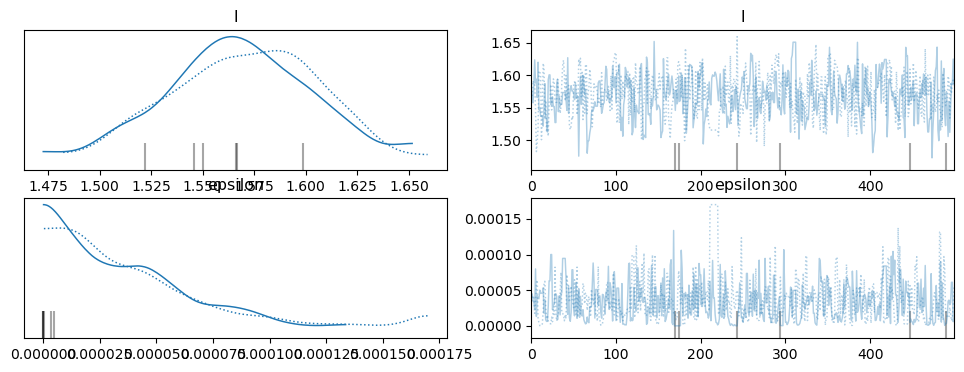

In [50]:
az.plot_trace(trace_reg)

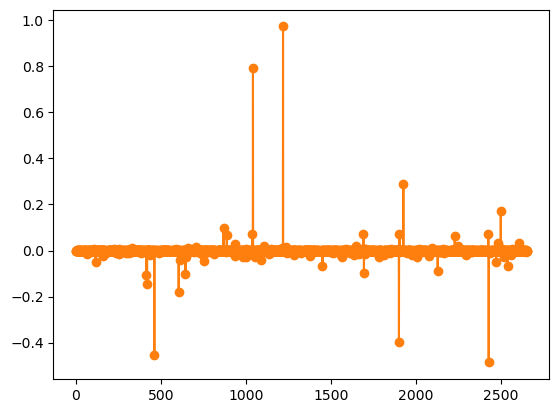

In [51]:

with pm.Model() as model_reg:
    mu, var = gp.predict(X_test, point=point, diag=True)
y_em_pymc3 = mu*y_std + y_mean
y_test_real = y_test*y_std+y_mean
plt.plot((y_em_pymc3 - y_test_real)/y_test_real , 'C1', marker='o')

normalised mean absolute error: 0.00081
normalised rmse: 0.0067
R2-score: 1.0


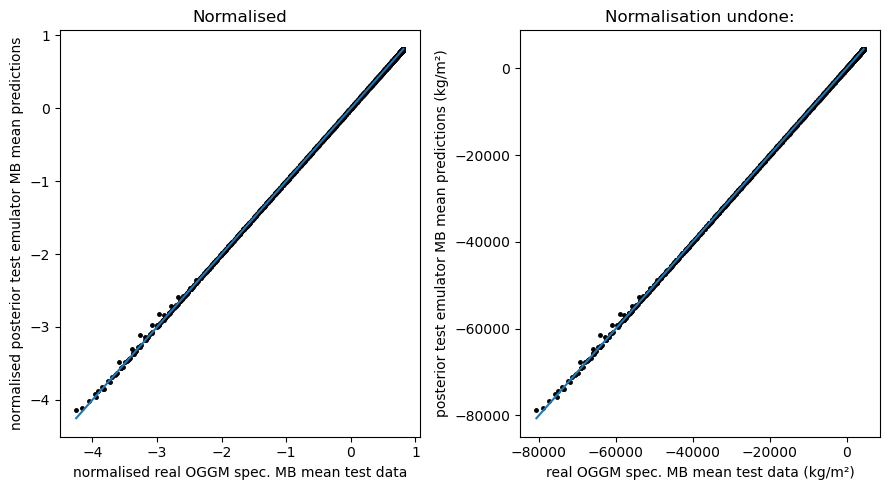

In [65]:

f, axs = plt.subplots(1, 2, figsize=(9, 5))
# Compare the modeled and emulated "test" mass balances (WITH normalisation)
ax = axs[0]
ax.set_title('Normalised')
mae_norm_l = []
rmse_norm_l = []
#for i in range(min(num_samples, 25)):
#y_pred_mean = y_pred.mean[i].detach().numpy()[idx]
ax.plot(y_test, mu, 'k.', ms=5)

ax.plot([y_test.min(),y_test.max()], [y_test.min(), y_test.max()])




ax.set_xlabel('normalised real OGGM spec. MB mean test data')
ax.set_ylabel('normalised posterior test emulator MB mean predictions')

ax = axs[1]
ax.set_title('Normalisation undone:')

ax.plot(y_test_real, y_em_pymc3, 'k.', ms=5)
ax.plot([y_test_real.min(),y_test_real.max()], [y_test_real.min(), y_test_real.max()])


plt.tight_layout()
ax.set_ylabel('posterior test emulator MB mean predictions (kg/m²)')
ax.set_xlabel('real OGGM spec. MB mean test data (kg/m²)')

mae = sklearn.metrics.mean_absolute_error(y_test, mu)
rmse = sklearn.metrics.mean_squared_error(y_test, mu, squared = False)
print(f'normalised mean absolute error: {mae:.2}')
print(f'normalised rmse: {rmse:.2}')
r2_test_data = sklearn.metrics.r2_score(y_test_real, y_em_pymc3)
print(f'R2-score: {r2_test_data:.2}')
plt.tight_layout()

In [66]:
# we look at the normalise MAE, RMSE and R2
print(sklearn.metrics.mean_absolute_error(mu, y_test))
print(sklearn.metrics.mean_squared_error(mu, y_test, squared=True))
print(sklearn.metrics.r2_score(mu, y_test))

0.0008082034557403879
4.458354063020521e-05
0.9999562413807179


ok, the emulator seems to work, however I need to make it faster (probably changing some setting, the amount of training params ...)

**how to merge the "emulator" from above into the mu (melt_f,  temp. b) below**
(to replace the aet_slope... stuff)

the code below does not work as the "slice" sampler is just stuck at 0 ... 

In [ ]:
### also see http://localhost:8888/lab/tree/Schreibtisch/PhD/WP0_bayesian/think_bayesian_dummy.ipynb

# somehow it works (slowly) in case of TIModel but not for PastMassBalance model --> not really sure why....
#mb_mod = TIModel(gdir, 150, mb_type='mb_monthly', prcp_fac=mb_mod.prcp_fac,
#                    grad_type='cte', input_filesuffix='')

# max. of specific MB until actually entire glacier melts away
max_allowed_specificMB = -100000
random_seed = 42

ityp_l = [at.dscalar, at.dscalar]
otyp = at.dscalar

# does not work because there is utils.clip inside which does somewhere > or < 
# that is not compatible with aeasara
@aesara.compile.ops.as_op(itypes=ityp_l, otypes=[otyp])
def get_spec_avg_mb(melt_f,t_b): #mb_mod, hgts, widths 
    mb_mod.mu_star = melt_f
    mb_mod.temp_bias = t_b
    spec_mb = mb_mod.get_specific_mb(heights=hgts, widths=widths,
                                     year=np.arange(2000, 2020, 1))
    return np.array(spec_mb.mean())


with pm.Model() as model: 
    # Define priors
    # recommended statistically --> intrinsic scatter of model fit
    # std. of geodetic observations (only works because I have only one observation!!!)
    sigma = pm.Data('sigma', [171])  # pm.HalfNormal("sigma", sd=5)  
    
    t_b = pm.TruncatedNormal('t_b', mu=0, sigma=2,
                            lower=-8, upper=8)
    melt_f = pm.TruncatedNormal('melt_f',
                                mu=250,
                                sigma=200,
                                lower=1, upper=1000)
    
    # model fit
    #aet_slope_melt_fs = pm.Data('aet_slope_melt_fs',
    #                                        [np.array(slope_melt_f).mean()])
    #aet_slope_pfs = pm.Data('aet_slope_pfs',
    #                                    [np.array(slope_pf).mean()])

    # Define model specification
    #mu = melt_f*aet_slope_melt_fs + pf*aet_slope_pfs

    mu = get_spec_avg_mb(melt_f,t_b)
    # geodetic observations
    observed = pm.Data('observed', [-1210]) # for Aletsch glacier
    max_allowed_specificMB_pm = pm.Data('max_allowed_specificMB', [max_allowed_specificMB])

    prior = pm.sample_prior_predictive(random_seed=random_seed, #cores=cores,
                                           samples=1000)  # , keep_size = True)
    
    # Fit likelihood * prior
    posterior = pm.TruncatedNormal("posterior", 
                                   mu = get_spec_avg_mb(melt_f, t_b),
                                   #mu = mu,
                                   sigma=sigma,
                                   observed=observed, 
                                   lower = max_allowed_specificMB) #max_allowed_specificMB_pm)

    
    # Inference!
    #step = pm.CompoundStep([pm.Metropolis(melt_f), pm.Metropolis(t_b)])
    #start = pm.find_MAP()
    #trace = pm.sample(mcmc_sample_no, chains=n_chains) #, step = step )
    trace = pm.sample(5000, cores=3, return_inferencedata=True) #, initvals=start)
    #az.concat(trace, az.from_dict(posterior_predictive=ppc, prior=prior),
    #                  inplace=True)
    
    # already 1000 per chain burnt
    ppc = pm.sample_posterior_predictive(trace, #cores=cores,
                                                 random_seed=random_seed,
                                                 var_names=['posterior',
                                                            't_b', 'melt_f',
                                                            #'mu',
                                                           ],
                                                 keep_size=True)
    

below is the old way which works, where I actually use the simple linear MB model, but this does not work anymore if I include temp. biases where the model gets non-linear ...

In [52]:
### this dummy simplified model (here temp. b = 0) works because the MB model is still linear,
# but the concept would be similar
slope_pf = 2
slope_melt_f = 5
melt_f_prior_mean = 250
melt_f_prior_sigma = 50
# max. of specific MB until actually entire glacier melts away
max_allowed_specificMB = -100000
random_seed = 42
with pm.Model() as model: 
    # Define priors
    # recommended statistically --> intrinsic scatter of model fit
    # std. of geodetic observations (only works because I have only one observation!!!)
    sigma = pm.Data('sigma', [200])  # pm.HalfNormal("sigma", sd=5)  
    
    pf = pm.TruncatedNormal('pf', mu=2, sigma=1,
                            lower=0.5, upper=5)
    melt_f = pm.TruncatedNormal('melt_f',
                                mu=250,
                                sigma=100,
                                lower=50, upper=400)
    
    # model fit
    aet_slope_melt_fs = pm.Data('aet_slope_melt_fs',
                                            [np.array(slope_melt_f).mean()])
    aet_slope_pfs = pm.Data('aet_slope_pfs',
                                        [np.array(slope_pf).mean()])

    # Define model specification
    mu = melt_f*aet_slope_melt_fs + pf*aet_slope_pfs
    
    ## WHAT I NEED INSTEAD:
    
    # geodetic observations
    observed = pm.Data('observed', [-1210]) # geodetic observation of Aletsch glacier
    
    max_allowed_specificMB_pm = pm.Data('max_allowed_specificMB', [max_allowed_specificMB])

    prior = pm.sample_prior_predictive(random_seed=random_seed, #cores=cores,
                                           samples=1000)  # , keep_size = True)
    
    # Fit likelihood * prior
    posterior = pm.TruncatedNormal("posterior", 
                          mu = mu,
                          sigma=sigma, observed=observed, 
                                  lower = max_allowed_specificMB_pm)

    
    # Inference!
    trace = pm.sample(10000, cores=3, return_inferencedata=True)
    #az.concat(trace, az.from_dict(posterior_predictive=ppc, prior=prior),
    #                  inplace=True)
    
    # already 1000 per chain burnt
    ppc = pm.sample_posterior_predictive(trace, #cores=cores,
                                                 random_seed=random_seed,
                                                 var_names=['posterior',
                                                            'pf', 'melt_f',
                                                            #'mu',
                                                           ],
                                                 keep_size=True)
    

/home/lilianschuster/anaconda3/envs/pymc_env/lib/python3.10/site-packages/pymc/data.py:671: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [pf, melt_f]



KeyboardInterrupt



array([[<AxesSubplot: title={'center': 'posterior'}>,
        <AxesSubplot: title={'center': 'posterior'}>],
       [<AxesSubplot: title={'center': 'pf'}>,
        <AxesSubplot: title={'center': 'pf'}>],
       [<AxesSubplot: title={'center': 'melt_f'}>,
        <AxesSubplot: title={'center': 'melt_f'}>]], dtype=object)

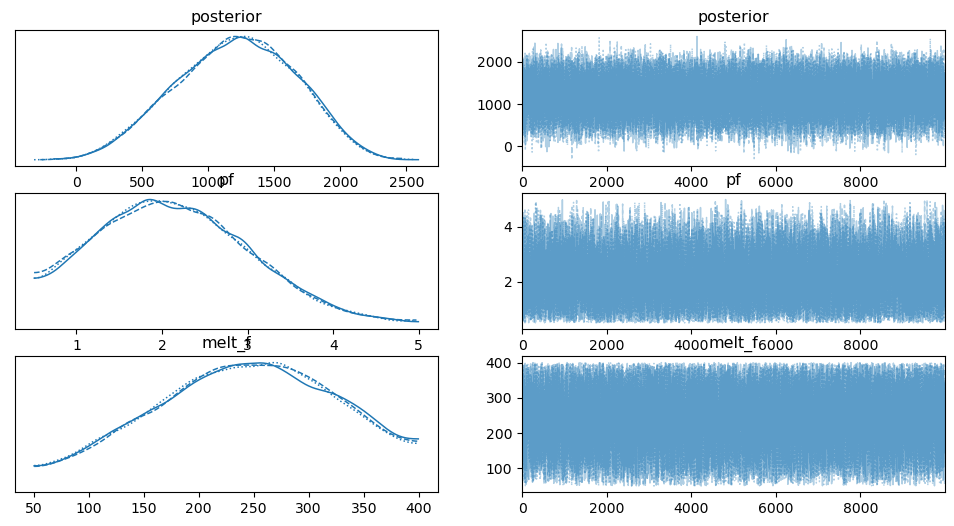

In [28]:
az.plot_trace(ppc.posterior_predictive)

# C: Use numpyro (with JAX) for GP regresion stuff <a id='C'></a>

- maybe do sth. like in this tutorial here? : 
    - https://num.pyro.ai/en/stable/examples/gp.html
    - https://num.pyro.ai/en/stable/tutorials/bayesian_hierarchical_linear_regression.html 

# Appendix <a id='appendix'></a>

## Other ideas: try to import pytorch GPR into PYMC
- problem, the example code from from https://dfm.io/posts/pymc-pytorch/ only works for scalar input but we don't have that ...

In [48]:
# adapted from https://dfm.io/posts/pymc-pytorch/
import aesara
import aesara.tensor as at


class TorchOp(at.Op):
    def __init__(self, module, params, args=None):
        self.module = module
        self.params = list(params)
        if args is None:
            self.args = tuple()
        else:
            self.args = tuple(args)

    def make_node(self, *args):
        if len(args) != len(self.params):
            raise ValueError("dimension mismatch")
        args = [at.as_tensor_variable(a) for a in args]
        return aesara.graph.basic.Apply(
            self, args, [at.dscalar().type()] + [a.type() for a in args]
        )

    def infer_shape(self, *args):
        shapes = args[-1]
        return tuple([()] + list(shapes))

    def perform(self, node, inputs, outputs):
        for p, value in zip(self.params, inputs):
            p.data = torch.tensor(value)
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

        result = self.module(*self.args)
        result.backward()

        outputs[0][0] = result.detach().numpy()
        for i, p in enumerate(self.params):
            outputs[i + 1][0] = p.grad.numpy()

    def grad(self, inputs, gradients):
        for i, g in enumerate(gradients[1:]):
            if not isinstance(g.type, aesara.gradient.DisconnectedType):
                raise ValueError(
                    "can't propagate gradients wrt parameter {0}".format(i + 1)
                )
        return [gradients[0] * d for d in self(*inputs)[1:]]

# It's useful to select the parameters directly instead of using model.parameters()
# so that we make sure that the order is as expected
#params = [model.m, model.b, model.logs]
params = [model.likelihood, model.mean_module, model.covar_module]


# The "forward" method of the torch op takes the data as well
args = [torch.tensor(x, dtype=torch.double), torch.tensor(y_obs, dtype=torch.double)]

# Finally put it all together
op = TorchOp(model, params, args=args)

NameError: name 'x' is not defined

----

----

## Appendix 2: not important only if we try to find other solutions (ignore this for the moment ... includes old trials w. PyMC3 GP regression and scikit-learn GPRs)

In [ ]:
# not necessary 
import oggm
from oggm import cfg, utils, workflow, tasks, graphics, entity_task
from oggm.core import massbalance, flowline, climate
from oggm.utils import (floatyear_to_date, date_to_floatyear)

# just for the graphics
SMALL_SIZE = 22
MEDIUM_SIZE = 24
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)        # a # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


cfg.initialize(logging_level='CRITICAL')
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['continue_on_error'] = False

working_dir = utils.gettempdir(dirname='OGGM_hydro_gp', reset=False)

cfg.PATHS['working_dir'] = working_dir
# use elevation band  flowlines
base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')

# as we calibrate to geodetic estimates we use calendar years!  
# need to check if this works in southern hemisphere
cfg.PARAMS['hydro_month_nh'] = 1


columns = ['prcp_fac', 'melt_f', 'temp_bias', 'spec_mb_mean']
columns = [*columns, *np.arange(2000, 2020,1).astype(str)]

from oggm import utils
# get the geodetic calibration data
url = 'https://cluster.klima.uni-bremen.de/~oggm/geodetic_ref_mb/hugonnet_2021_ds_rgi60_pergla_rates_10_20_worldwide.csv'
path_geodetic = utils.file_downloader(url)
pd_geodetic_all = pd.read_csv(path_geodetic, index_col='rgiid')
pd_geodetic = pd_geodetic_all.loc[pd_geodetic_all.period == '2000-01-01_2020-01-01']

#### save the emulator

In [ ]:
import pickle

gdir = gdirs[0]
y_cn = 'mb_kgm2'
# Save emulator (model state, x_train, y_train, etc.)
em_mod_fn = gdir.rgi_id + '-emulator-' + y_cn + '.pth'
#em_mod_fp = em_fp + 'models/' + glacier_str.split('.')[0].zfill(2) + '/'
em_mod_fp = '/home/lilianschuster/Schreibtisch/PhD/GP/emulator_model/'
if not os.path.exists(em_mod_fp):
    os.makedirs(em_mod_fp, exist_ok=True)
torch.save(model.state_dict(), em_mod_fp + em_mod_fn)
# Extra required datasets
em_extra_dict = {'X_train': X_train,
                 'X_mean': X_mean,
                 'X_std': X_std,
                 'y_train': y_train,
                 'y_mean': y_mean,
                 'y_std': y_std}
em_extra_fn = em_mod_fn.replace('.pth','_extra.pkl')
with open(em_mod_fp + em_extra_fn, 'wb') as f:
    pickle.dump(em_extra_dict, f)
        
#return X_train, X_mean, X_std, y_train, y_mean, y_std, likelihood, model

#### load saved emulator


In [ ]:
state_dict = torch.load(em_mod_fp + em_mod_fn)

emulator_extra_fn = em_mod_fn.replace('.pth','_extra.pkl')
with open(em_mod_fp + emulator_extra_fn, 'rb') as f:
    emulator_extra_dict = pickle.load(f)

X_train = emulator_extra_dict['X_train']
X_mean = emulator_extra_dict['X_mean']
X_std = emulator_extra_dict['X_std']
y_train = emulator_extra_dict['y_train']
y_mean = emulator_extra_dict['y_mean']
y_std = emulator_extra_dict['y_std']

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Create a new GP model
model = ExactGPModel(X_train, y_train, likelihood)  
model.load_state_dict(state_dict)
model.eval()

In [ ]:
### possibility to load pytorch model into pymc ???
# see https://dfm.io/posts/pymc-pytorch/
params = [model.mean_module, model.covar_module]

# The "forward" method of the torch op takes the data as well
args = [torch.tensor(X, dtype=torch.double), torch.tensor(y_obs, dtype=torch.double)]

# Finally put it all together
op = TorchOp(model, params, args=args)

# --> from ere: try out 		- https://dfm.io/posts/pymc-pytorch/

In [2]:
# import the MSsandbox modules
from MBsandbox.mbmod_daily_oneflowline import MultipleFlowlineMassBalance_TIModel
from MBsandbox.mbmod_daily_oneflowline import process_w5e5_data, process_era5_daily_data, TIModel, TIModel_Sfc_Type, BASENAMES
# from MBsandbox.help_func import compute_stat, minimize_bias, optimize_std_quot_brentq
from MBsandbox.help_func import minimize_bias_geodetic, optimize_std_quot_brentq_geod, melt_f_calib_geod_prep_inversion
from MBsandbox.flowline_TIModel import (run_from_climate_data_TIModel, run_constant_climate_TIModel,
                                        run_random_climate_TIModel)
from MBsandbox.wip.projections_bayescalibration import process_isimip_data

ModuleNotFoundError: No module named 'pymc3'

In [3]:
# if you have a precipitation factor from the hydrological model you can change it here
pf = 2  # we set the precipitation factor here to 1
climate_type = 'W5E5' #W5E5 # 'WFDE5_CRU'
#climate_type='WFDE5_CRU' -> need to use other pf and temp_bias ... 
#mb_type = 'mb_real_daily' #real daily input, this would be monthly input:'mb_monthly' #'mb_real_daily' # 'mb_monthly'#
mb_type = 'mb_monthly'
#grad_type ='var_an_cycle' # variable lapse rates
grad_type = 'cte'
ensemble = 'mri-esm2-0_r1i1p1f1'
ssp = 'ssp126'
dataset = climate_type

In [ ]:
#df = ['RGI60-11.00890', 
#df = ['RGI60-11.00897'] # list of glaciers -> can be longer ... 
df = ['RGI60-11.01450'] # list of glaciers -> can be longer ... 

# this has to be done just once for a region (basin) (independent of climate, mb_type, prcp-fac ... )
init = True
if init:
    gdirs = workflow.init_glacier_directories(df, from_prepro_level=2,
                                              prepro_border=80,
                                              prepro_base_url=base_url,
                                              prepro_rgi_version='62')
    workflow.execute_entity_task(tasks.compute_downstream_line, gdirs)
    workflow.execute_entity_task(tasks.compute_downstream_bedshape, gdirs)
    
    # get the climate data (either w5e5 or WFDE5_CRU)
    workflow.execute_entity_task(process_w5e5_data, gdirs,
                                 temporal_resol='monthly', climate_type=climate_type)
    workflow.execute_entity_task(process_w5e5_data, gdirs,
                                 temporal_resol='daily', climate_type=climate_type)
else:
    gdirs = workflow.init_glacier_directories(df)

In [4]:
# this has to be done once for each climate, mb_type, grad_type, pf option,
# then you can save the melt_f and a-factor for the runs later on 

if climate_type =='W5E5' or climate_type == 'W5E5_MSWEP':
    ye=2020 # till end of 2019
else:
    ye=2019
    
if mb_type == 'mb_real_daily':
    temporal_resol = 'daily'
else:
    temporal_resol = 'monthly'


from MBsandbox.help_func import calib_inv_run

In [5]:
import seaborn as sns
import pymc as pm
import arviz as az
import aesara as aet

## test data from scikit example

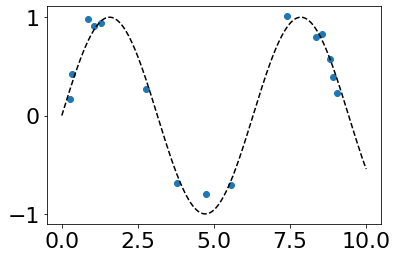

In [6]:
x = np.random.uniform(0, 10, size=15)
y = np.random.normal(np.sin(x), 0.1)
y = np.random.normal(np.sin(x), 0.1)
X = x[:, None]
plt.plot(x, y, 'o')
true_x = np.linspace(0, 10, 200)
plt.plot(true_x, np.sin(true_x), 'k--')
Y=y

## test mb data from HEF

In [7]:
gd = gdirs[-1]

In [8]:

    rho_geodetic = 850

    # get volume estimates
    dV = pd.read_hdf(utils.get_demo_file('rgi62_itmix_df.h5'))

    # for potential restricting total ice melt
    V_gd_m3 = dV.loc[gd.rgi_id]['vol_itmix_m3']  # m3 volume of HEF
    total_mass_gd = V_gd_m3 * rho_geodetic
    # this is the area from 2000, could use another estimate (e.g. mean between 2000 and 2020...)
    gd_area = pd_geodetic.loc[gd.rgi_id]['area']  # in m2 now !!!
    # convert kg --> kg/km2
    max_allowed_specificMB = - total_mass_gd / gd_area

In [9]:
max_allowed_specificMB

-142197.2962739946

In [10]:
mb_mod = TIModel(gdirs[-1], None, mb_type=mb_type, grad_type=grad_type, baseline_climate=climate_type, residual=0)
mb_mod_sfc = TIModel_Sfc_Type(gdirs[-1], None, mb_type=mb_type, grad_type=grad_type, baseline_climate=climate_type, residual=0)

fs = '_daily_{}'.format(climate)
h, w = gdirs[-1].get_inversion_flowline_hw()


In [13]:
from MBsandbox.wip.bayes_calib_geod_direct import get_slope_pf_melt_f
slope_pf, slope_melt_f = get_slope_pf_melt_f(mb_mod, h=h, w=w, ys=np.arange(2000,2020,1))
aet_slope_melt_fs = pm.Data('aet_slope_melt_fs',
                                        [np.array(slope_melt_f).mean()])
aet_slope_pfs = pm.Data('aet_slope_pfs',
                                    [np.array(slope_pf).mean()])

TypeError: No model on context stack, which is needed to instantiate a data container. Add variable inside a 'with model:' block.

In [7]:
columns = ['prcp_fac', 'melt_f', 'temp_bias', 'spec_mb_mean']
columns = [*columns, *np.arange(2000, 2020,1).astype(str)]

In [8]:
import datetime
start_time = datetime.datetime.now()

pd_spec_mb = pd.DataFrame(columns = columns)
pd_spec_mb_sfc = pd.DataFrame(columns = columns)


#melt_f = 200
#spec_mbs = {}
load = False
if load:
    j = 0
    for temp_bias in np.arange(-10, 10, 1):
        for prcp_fac in [0.1, 0.5, 1, 1.5, 2, 3,4, 5, 6,7,8,9, 10]:
            for melt_f in np.arange(10,1000, 100):
                mb_mod.prcp_fac = prcp_fac
                mb_mod.melt_f = melt_f
                mb_mod.temp_bias = temp_bias
                mb_mod_sfc.prcp_fac = prcp_fac
                mb_mod_sfc.melt_f = melt_f
                mb_mod_sfc.temp_bias = temp_bias


                # just check if calibration worked ...
                spec_mb = mb_mod.get_specific_mb(heights=h, widths=w,
                                                 year=np.arange(2000, 2020, 1))
                spec_mb_mean = spec_mb.mean()
                spec_mb_sfc = mb_mod_sfc.get_specific_mb(heights=h, widths=w,
                                                 year=np.arange(2000, 2020, 1))
                spec_mb_sfc_mean = spec_mb_sfc.mean()

                #spec_mbs[prcp_fac] = spec_mb
                pd_spec_mb.loc[j] = np.concatenate((np.array([prcp_fac, melt_f, temp_bias, spec_mb_mean]), spec_mb))
                pd_spec_mb_sfc.loc[j] = np.concatenate((np.array([prcp_fac, melt_f, temp_bias, spec_mb_sfc_mean]), spec_mb_sfc))

                j+=1

    end_time = datetime.datetime.now()
    pd_spec_mb.to_csv('test_mb.csv')
    pd_spec_mb_sfc.to_csv('test_mb_sfc.csv')
else:
    pd_spec_mb = pd.read_csv('test_mb.csv', index_col=[0])
    pd_spec_mb_sfc = pd.read_csv('test_mb.csv', index_col=[0])

In [9]:
pd_spec_mb

,prcp_fac,melt_f,temp_bias,spec_mb_mean,2000,2001,2002,2003,2004,2005,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,0.1,10.0,-10.0,249.497285,257.999123,281.715771,325.472346,188.311966,250.568443,220.661988,...,242.010102,212.109117,278.052507,252.253138,252.650466,223.506703,249.198989,251.160807,246.328254,262.702112
1,0.1,110.0,-10.0,238.530753,255.137577,276.722614,322.620239,165.595751,248.647625,218.715284,...,233.147596,208.658898,270.623999,238.687797,251.727777,181.412191,241.203183,235.759407,221.086276,244.580977
2,0.1,210.0,-10.0,227.564221,252.276030,271.729456,319.768132,142.879536,246.726807,216.768580,...,224.285090,205.208678,263.195491,225.122456,250.805089,139.317678,233.207378,220.358007,195.844299,226.459841
3,0.1,310.0,-10.0,216.597689,249.414484,266.736299,316.916025,120.163320,244.805989,214.821875,...,215.422584,201.758459,255.766983,211.557115,249.882401,97.223166,225.211572,204.956608,170.602321,208.338706
4,0.1,410.0,-10.0,205.631157,246.552938,261.743142,314.063917,97.447105,242.885171,212.875171,...,206.560078,198.308239,248.338475,197.991774,248.959712,55.128653,217.215766,189.555208,145.360344,190.217570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595,10.0,510.0,9.0,-24407.322856,-24343.947581,-19730.473853,-23285.536576,-26164.220737,-20722.754882,-23426.201461,...,-21175.188653,-27754.047912,-22808.636295,-22163.939435,-28533.674327,-29127.638797,-24401.354247,-25704.297463,-28508.787298,-26579.930961
2596,10.0,610.0,9.0,-30988.819800,-30828.596772,-25893.483660,-29607.249194,-32890.543266,-26811.825062,-29671.600844,...,-26884.265287,-34615.719085,-29417.385501,-28413.362346,-35387.632375,-36296.613827,-30918.870563,-32631.655735,-36274.669127,-33640.051469
2597,10.0,710.0,9.0,-37570.316745,-37313.245964,-32056.493468,-35928.961812,-39616.865795,-32900.895241,-35917.000227,...,-32593.341921,-41477.390257,-36026.134707,-34662.785257,-42241.590423,-43465.588856,-37436.386879,-39559.014007,-44040.550956,-40700.171977
2598,10.0,810.0,9.0,-44151.813690,-43797.895156,-38219.503276,-42250.674430,-46343.188323,-38989.965421,-42162.399610,...,-38302.418555,-48339.061429,-42634.883913,-40912.208168,-49095.548471,-50634.563886,-43953.903195,-46486.372280,-51806.432786,-47760.292486


In [134]:
# remove those columns where the (negative) MB exceeds the 

In [106]:
import pickle
# Save emulator (model state, x_train, y_train, etc.)
em_mod_fn = gdir.rgi_id + '-emulator-' + y_cn + '.pth'
#em_mod_fp = em_fp + 'models/' + glacier_str.split('.')[0].zfill(2) + '/'
em_mod_fp = '/home/lilianschuster/Schreibtisch/PhD/GP/emulator_model/'
if not os.path.exists(em_mod_fp):
    os.makedirs(em_mod_fp, exist_ok=True)
torch.save(model.state_dict(), em_mod_fp + em_mod_fn)
# Extra required datasets
em_extra_dict = {'X_train': X_train,
                 'X_mean': X_mean,
                 'X_std': X_std,
                 'y_train': y_train,
                 'y_mean': y_mean,
                 'y_std': y_std}
em_extra_fn = em_mod_fn.replace('.pth','_extra.pkl')
with open(em_mod_fp + em_extra_fn, 'wb') as f:
    pickle.dump(em_extra_dict, f)
        
#return X_train, X_mean, X_std, y_train, y_mean, y_std, likelihood, model

#### load saved emulator

In [108]:
#### load saved emulator
state_dict = torch.load(em_mod_fp + em_mod_fn)

emulator_extra_fn = em_mod_fn.replace('.pth','_extra.pkl')
with open(em_mod_fp + emulator_extra_fn, 'rb') as f:
    emulator_extra_dict = pickle.load(f)

X_train = emulator_extra_dict['X_train']
X_mean = emulator_extra_dict['X_mean']
X_std = emulator_extra_dict['X_std']
y_train = emulator_extra_dict['y_train']
y_mean = emulator_extra_dict['y_mean']
y_std = emulator_extra_dict['y_std']

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Create a new GP model
model = ExactGPModel(X_train, y_train, likelihood)  
model.load_state_dict(state_dict)
model.eval()

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [ ]:
# see https://dfm.io/posts/pymc-pytorch/
params = [model.mean_module, model.covar_module]

# The "forward" method of the torch op takes the data as well
args = [torch.tensor(X, dtype=torch.double), torch.tensor(y_obs, dtype=torch.double)]

# Finally put it all together
op = TorchOp(model, params, args=args)

# --> from ere: try out 		- https://dfm.io/posts/pymc-pytorch/

--> from ere: try out 		- https://dfm.io/posts/pymc-pytorch/

In [ ]:
                    # Mass balance emulator function
                    def run_emulator_mb(modelprms):
                        """ Run the emulator
                        """
                        modelprms_1d_norm = ((np.array([modelprms['tbias'], modelprms['kp'], modelprms['ddfsnow']]) - 
                                              X_mean) / X_std)                    
                        modelprms_2d_norm = modelprms_1d_norm.reshape(1,3)
                        mb_mwea_norm = em_model_mb(
                                torch.tensor(modelprms_2d_norm).to(torch.float)).mean.detach().numpy()[0]
                        mb_mwea = mb_mwea_norm * y_std + y_mean
                        return mb_mwea

--> to actually use some kind of `run_emulator_mb` --> I need to make it `aesara` compatible!!!

In [ ]:
                    # ===== DETERMINISTIC FUNCTION ====
                    # Define deterministic function for MCMC model based on our a priori probobaility distributions.
                    @deterministic(plot=False)
                    def massbal(tbias=tbias, kp=kp, ddfsnow=ddfsnow):
                        """ Likelihood function for mass balance [mwea] based on model parameters """
                        modelprms_copy = modelprms.copy()
                        if tbias is not None:
                            modelprms_copy['tbias'] = float(tbias)
                        if kp is not None:
                            modelprms_copy['kp'] = float(kp)
                        if ddfsnow is not None:
                            modelprms_copy['ddfsnow'] = float(ddfsnow)
                            modelprms_copy['ddfice'] = modelprms_copy['ddfsnow'] / pygem_prms.ddfsnow_iceratio
#                        mb_mwea = mb_mwea_calc(gdir, modelprms_copy, glacier_rgi_table, fls=fls)
                        mb_mwea = run_emulator_mb(modelprms_copy)
                        return mb_mwea

### Pymc3 and Gumbi
- https://discourse.pymc.io/t/gaussian-process-regression-pymc3-much-slower-than-scikit-learn/6874
- https://pymc-learn.readthedocs.io/en/latest/_modules/pmlearn/gaussian_process/gpr.html#GaussianProcessRegressor
--> actually I have used https://johngoertz.github.io/Gumbi/  to do that, but how do I go on from there? How to include the priors and geodetic uncertainties  / observation to also driectly calibrate on that???

In [190]:
pd_spec_mb = pd_spec_mb[np.abs(pd_spec_mb['temp_bias']) <5.1]
# normalize data 
X = pd_spec_mb[['temp_bias','prcp_fac','melt_f'] ].values 
y = pd_spec_mb['spec_mb_mean'].values

import sklearn.model_selection
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

y_mean = y.mean()
y_std = y.std()

y_norm = (y - y_mean) / y_std

# Split into training and test data and cast to torch tensors
#X_train,X_test,y_train,y_test = [torch.tensor(x).to(torch.float) 
#                                 for x in sklearn.model_selection.train_test_split(X_norm,y_norm)]

X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X_norm,y_norm, test_size=0.9)

In [191]:
lengthscale = 2
eta = 2.0
cov = eta ** 2 * pm.gp.cov.ExpQuad(1, lengthscale)
# Add white noise to stabilise
cov += pm.gp.cov.WhiteNoise(1e-6)

X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

plt.figure(figsize=(14, 4))

plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, shape=K.shape[0]).random(size=3).T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

(143, 3)

In [ ]:
import gumbi as gmb
import seaborn as sns

pd_spec_mb_sel = pd_spec_mb[pd_spec_mb['prcp_fac']==1]
pd_spec_mb_sel_sel = pd_spec_mb_sel[pd_spec_mb_sel['temp_bias'] == 0]
#pd_spec_mb_sel = sns.load_dataset('mpg').dropna()
ds = gmb.DataSet(pd_spec_mb_sel_sel, outputs=['spec_mb_mean']) #, log_vars=['spec_mb_mean', 'melt_f'])
gp = gmb.GP(ds)
gp.fit(outputs=['spec_mb_mean'], continuous_dims=['melt_f']);
model_T = pm.Model()

with model_T:
    # let's assume fake dists
    #pf = pm.TruncatedNormal('pf', mu=1.8,
    #                                    sigma=0.5,
    #                                    lower=0.5, upper=10)
    melt_f = pm.TruncatedNormal('melt_f', mu=160,
                                          sigma=100,
                                lower=10, upper=1000)
    #temp_bias = pm.TruncatedNormal('temp_bias', mu=0, sigma=3, lower=-5, upper = 5)
    
    mb_mod = pm.Deterministic('mb_mod', aet_mbs)


In [22]:
# this does not work?!
#gp.gp_dict['total'].(np.arange(10,500,10)[:,None])
#with gp.model() as model:
point = gp.parray(melt_f = np.arange(10,1000,10))
gp.predict_points(point, with_noise=False)
    

spec_mb_mean['μ', 'σ2']: [( 1896.52342004, 10.80164885) ( 1775.6534802 ,  9.32736483)
 ( 1654.76622106,  8.10011861) ( 1533.86212596,  7.0897261 )
 ( 1412.94167219,  6.26855779) ( 1292.00533105,  5.61139871)
 ( 1171.05356808,  5.09531097) ( 1050.08684306,  4.69950435)
 (  929.10561026,  4.40520681) (  808.11031852,  4.19554301)
 (  687.10141136,  4.05541478) (  566.07932717,  3.97138683)
 (  445.04449931,  3.93157592) (  323.99735622,  3.92554479)
 (  202.93832161,  3.94419905) (   81.86781459,  3.97968859)
 (  -39.21375025,  4.02531262) ( -160.30596264,  4.07542838)
 ( -281.40841652,  4.12536356) ( -402.52070989,  4.17133231)
 ( -523.64244468,  4.21035465) ( -644.77322659,  4.24017962)
 ( -765.912665  ,  4.25921149) ( -887.06037276,  4.26643988)
 (-1008.21596608,  4.26137261) (-1129.37906441,  4.24397191)
 (-1250.54929027,  4.21459419) (-1371.72626909,  4.17393265)
 (-1492.90962911,  4.12296302) (-1614.09900119,  4.06289244)
 (-1735.29401872,  3.99511142) (-1856.49431742,  3.92114818)

In [120]:
gp.predict_points?

Signature: gp.predict_points(points, output=None, with_noise=True, **kwargs)
Docstring:
Make predictions at supplied points

Parameters
----------
points : ParameterArray
    1-D ParameterArray vector of coordinates for prediction, must have one layer per ``self.dims``
output : str or list of str, optional
    Variable for which to make predictions
with_noise : bool, default True
    Whether to incorporate aleatoric uncertainty into prediction error
**kwargs
    Additional keyword arguments passed to subclass-specific :meth:`predict` method

Returns
-------
prediction : UncertainParameterArray
    Predictions as a `uparray`
File:      ~/anaconda3/envs/pymc3_oggm/lib/python3.9/site-packages/gumbi/regression/base.py
Type:      method


In [89]:
pd_spec_mb_sel_sel[['spec_mb_mean', 'melt_f']]

,spec_mb_mean,melt_f
1320,1898.074809,10.0
1321,686.579656,110.0
1322,-524.915497,210.0
1323,-1736.410650,310.0
1324,-2947.905804,410.0
1325,-4159.400957,510.0
1326,-5370.896110,610.0
1327,-6582.391263,710.0
1328,-7793.886417,810.0
1329,-9005.381570,910.0


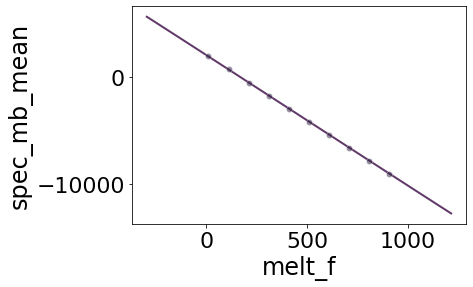

In [82]:
X = gp.prepare_grid()
y = gp.predict_grid()
gmb.ParrayPlotter(X, y).plot()
sns.scatterplot(data=pd_spec_mb_sel_sel, x='melt_f', y='spec_mb_mean', color=sns.cubehelix_palette()[-1], alpha=0.5);

#### 2D regression with / without linear kernel
- https://johngoertz.github.io/Gumbi/notebooks/examples/Cars_Dataset.html#2D-regression-with-and-without-linear-kernel

In [33]:
stdzr = gmb.Standardizer(melt_f=gp.stdzr['melt_f'],
                        temp_bias = gp.stdzr['temp_bias'])
limits= gmb.parray(**{'melt_f':[10,1000], 'temp_bias':[-5,5]}, stdzr=stdzr, stdzd=False) #, stdzd=True) #, stdzd=True)

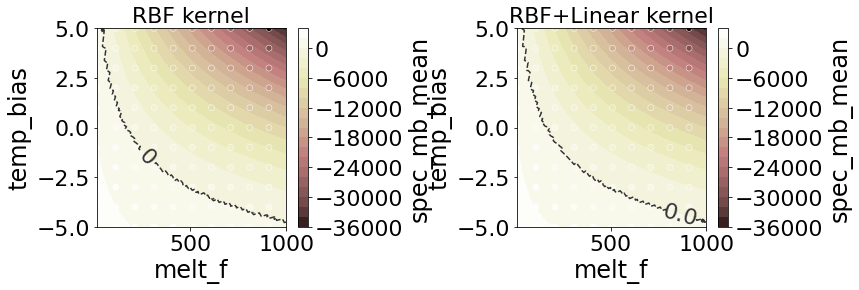

In [34]:
from matplotlib.colors import Normalize
norm = Normalize()
norm(ds.wide.spec_mb_mean);

gp = gmb.GP(ds)

axs = plt.subplots(1,2, figsize=(12, 4.5))[1]
for ax, linear in zip(axs, [False, True]):
    linear_dims = ['melt_f','temp_bias'] if linear else None

    gp.fit(outputs=['spec_mb_mean'], continuous_dims=['melt_f','temp_bias'], linear_dims=linear_dims);

    #XY = gp.prepare_grid()
    XY = gp.prepare_grid(limits=limits)
    X = XY['melt_f']
    Y = XY['temp_bias']
    z = gp.predict_grid()

    plt.sca(ax)
    pp = gmb.ParrayPlotter(X, Y, z)
    pp(plt.contourf, levels=20, cmap='pink',) #, norm=norm)
    pp.colorbar(ax=ax)

    cs = ax.contour(X.values(), Y.values(), z.σ/z.μ, levels=4, colors='0.2', linestyles='--')
    ax.clabel(cs)

    sns.scatterplot(data=pd_spec_mb_sel, x='melt_f', y='temp_bias', hue='spec_mb_mean', palette='pink', norm=norm, ax=ax);
    ax.legend().remove()

    title = 'RBF+Linear kernel' if linear else 'RBF kernel'
    ax.set_title(title)

plt.tight_layout()


#### 3 dimensions:

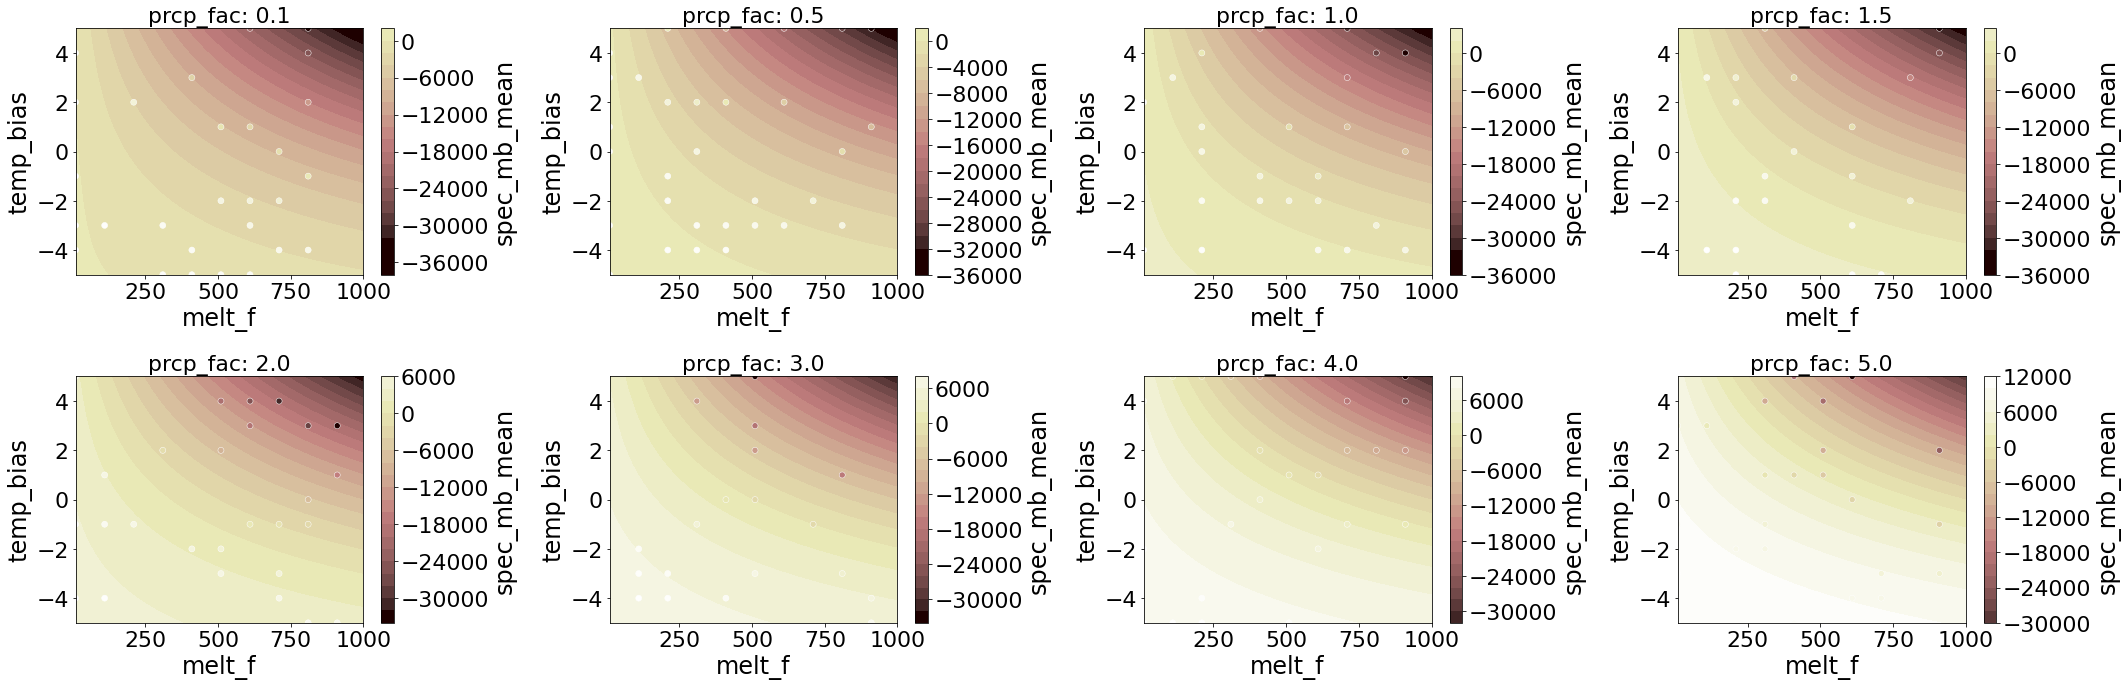

In [27]:
import gumbi as gmb
pd_spec_mb_s = pd_spec_mb[np.abs(pd_spec_mb['temp_bias']) <5.1]
pd_spec_mb_s = pd_spec_mb_s[np.abs(pd_spec_mb_s['prcp_fac']) <5.1]
pd_spec_mb_sample = pd_spec_mb.sample(n=200)
ds = gmb.DataSet(pd_spec_mb_sample, outputs=['spec_mb_mean']) #, log_vars=['spec_mb_mean', 'melt_f'])

prcp_fac = pd_spec_mb.prcp_fac.unique()
prcp_fac.sort()

gp = gmb.GP(ds)
gp.fit(outputs=['spec_mb_mean'],
       continuous_dims=['melt_f','temp_bias', 'prcp_fac']) #, linear_dims=['melt_f','temp_bias', 'prcp_fac']) #, linear_dims=['horsepower','weight', 'cylinders']);

from matplotlib.colors import Normalize
norm = Normalize()
norm(ds.wide.spec_mb_mean);

stdzr = gmb.Standardizer(melt_f=gp.stdzr['melt_f'],
                        temp_bias = gp.stdzr['temp_bias'])
limits= gmb.parray(**{'melt_f':[10,1000], 'temp_bias':[-5,5]}, stdzr=stdzr, stdzd=False) #, stdzd=True) #, stdzd=True)

linear = False #True
#axs = plt.subplots(2, 4, figsize=(30, 10))[1]
[axs1,axs2] = plt.subplots(2, 4, figsize=(30, 10))[1]

for j, pf in enumerate(prcp_fac):
    
    if j<4:
        ax = axs1[j]
    else:
        ax = axs2[j-4]

    XY = gp.prepare_grid(at=gp.parray(prcp_fac=pf), limits=limits)
    X = XY['melt_f']
    Y = XY['temp_bias']
    z = gp.predict_grid(with_noise=False)

    plt.sca(ax)
    pp = gmb.ParrayPlotter(X, Y, z)
    pp(plt.contourf, levels=20, cmap='pink', norm=norm)
    pp.colorbar(ax=ax)

    #cs = ax.contour(X.values(), Y.values(), z.σ, levels=4, colors='0.2', linestyles='--')
    #ax.clabel(cs)

    sns.scatterplot(data=pd_spec_mb_sample[pd_spec_mb_sample.prcp_fac==pf], x='melt_f', y='temp_bias', hue='spec_mb_mean', palette='pink', norm=norm, ax=ax);
    ax.legend().remove()

    title = 'RBF+Linear kernel' if linear else 'RBF kernel'
    ax.set_title(f'prcp_fac: {pf}')

plt.tight_layout()

In [28]:
index_test = []
for ind in pd_spec_mb.index:
    if ind not in pd_spec_mb_sample.index:
        index_test.append(ind)

In [29]:
points = gp.parray(melt_f = pd_spec_mb.loc[index_test].melt_f.values,
                   prcp_fac = pd_spec_mb.loc[index_test].prcp_fac.values,
                   temp_bias=pd_spec_mb.loc[index_test].temp_bias.values)
test_em_out = gp.predict_points(points, with_noise=False)
test_mu_em_out = []
for k in test_em_out:
    test_mu_em_out.append(k['μ'])

In [30]:
test_real_out = pd_spec_mb.loc[index_test].spec_mb_mean.values

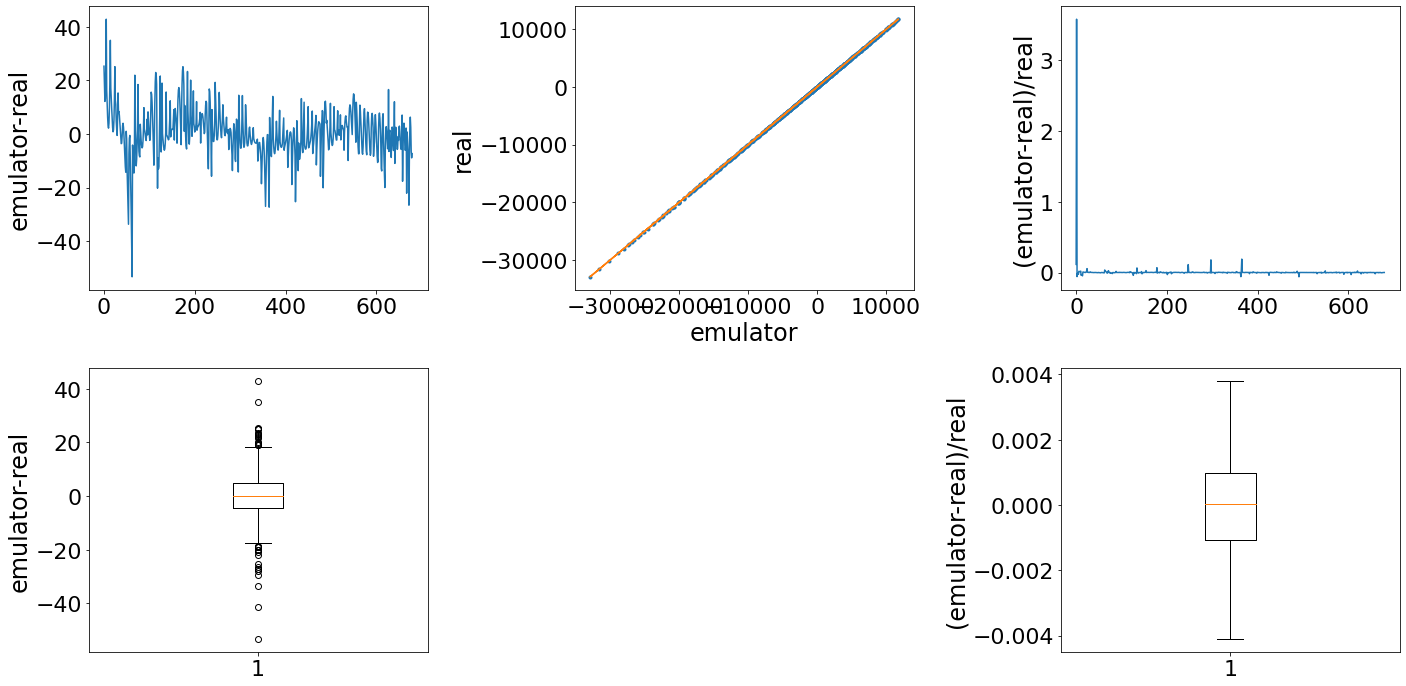

In [31]:
plt.figure(figsize=(20,10))
plt.subplot(231)
plt.plot(test_mu_em_out - test_real_out)
plt.ylabel('emulator-real')

plt.subplot(232)
plt.plot(test_mu_em_out, test_real_out, '.')
plt.plot(test_real_out, test_real_out, '-')
plt.ylabel('real')
plt.xlabel('emulator')

plt.subplot(233)
plt.plot((test_mu_em_out - test_real_out) / test_real_out)
plt.ylabel('(emulator-real)/real')

plt.subplot(234)
plt.boxplot(test_mu_em_out - test_real_out)
plt.ylabel('emulator-real')


plt.subplot(236)
plt.boxplot((test_mu_em_out - test_real_out) / test_real_out, showfliers=False)
plt.ylabel('(emulator-real)/real')

plt.tight_layout()

In [178]:
gp.cross_validate(['melt_f', 'prcp_fac', 'temp_bias'], pct_train = 200)
model_T = pm.Model()

with model_T:
    # let's assume fake dists
    pf = pm.TruncatedNormal('pf', mu=1.8,
                                        sigma=0.5,
                                        lower=0.5, upper=10)
    melt_f = pm.TruncatedNormal('melt_f', mu=160,
                                          sigma=100,
                                lower=10, upper=1000)
    temp_bias = pm.TruncatedNormal('temp_bias', mu=0, sigma=3, lower=-5, upper = 5)
    gp.d
mean_mb_em = gp.gp_dict['total'].conditional('mean_mb_em', points)

In [ ]:
with model_T:
    points = gp.parray(melt_f = melt_f,
                       prcp_fac = pf,
                       temp_bias=temp_bias)
    #test_em_out = gp.predict_points(points, with_noise=False)
    test_em_out = gp.predict(points, with_noise=False)
    gp.sample()
    mb_mod = pm.Deterministic('mb_mod', test_em_out)


In [41]:
len(pd_spec_mb)
#mp = gp.find_MAP()
#with gp.gp_dict['total'] as model:
#    mp = pm.find_map()
gp.cross_validate(['melt_f', 'prcp_fac', 'temp_bias'], n_train = 200)
gp.gp_dict['total'].predict(np.array([200,1,0]))

880

In [110]:
gp.gp_dict['total'].prior
#test_mean = pd_spec_mb.loc[index_test][['melt_f','temp_bias', 'prcp_fac']].values.mean(axis=0)
#test_std = pd_spec_mb.loc[index_test][['melt_f','temp_bias', 'prcp_fac']].values.std(axis=0)
train_mean = pd_spec_mb_sample[['melt_f','temp_bias', 'prcp_fac']].values.mean(axis=0)
train_std = pd_spec_mb_sample[['melt_f','temp_bias', 'prcp_fac']].values.std(axis=0)
#norm_test = (pd_spec_mb.loc[index_test][['melt_f','temp_bias', 'prcp_fac']].values-test_mean)/test_std
norm_test = (pd_spec_mb.loc[index_test][['melt_f','temp_bias', 'prcp_fac']].values-train_mean)/train_std

In [112]:
mu, var = gp.gp_dict['total'].predict(norm_test) #, point= gp.find_MAP(), diag=True)

In [114]:
# same as:
# pd_spec_mb_sample['spec_mb_mean'].std()
# np.sqrt(gp.stdzr['spec_mb_mean']['σ2'])
mu_emu_test = mu*np.sqrt(gp.stdzr['spec_mb_mean']['σ2']) + gp.stdzr['spec_mb_mean']['μ']

In [115]:
len(mu_emu_test)

680

{'whiskers': [<matplotlib.lines.Line2D at 0x7f27fab9feb0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f27faba0250>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f27d1153cd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f27faba08e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f27faa96430>],
 'means': []}

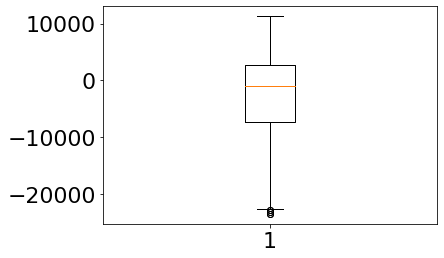

In [118]:
plt.boxplot(mu_emu_test)

In [ ]:
gp.gp_dict['total'].predict

### Pure GP model:

In [17]:
pd_spec_mb = pd_spec_mb[np.abs(pd_spec_mb['temp_bias']) <5.1]
# normalize data 
X = pd_spec_mb[['temp_bias','prcp_fac','melt_f'] ].values 
y = pd_spec_mb['spec_mb_mean'].values

import sklearn.model_selection
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

y_mean = y.mean()
y_std = y.std()

y_norm = (y - y_mean) / y_std

# Split into training and test data and cast to torch tensors
#X_train,X_test,y_train,y_test = [torch.tensor(x).to(torch.float) 
#                                 for x in sklearn.model_selection.train_test_split(X_norm,y_norm)]

X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X_norm,y_norm, test_size=0.8)

In [147]:
# https://discourse.pymc.io/t/pm-sample-gets-stuck-after-init-with-cores-1/5017/17
with pm.Model() as model_reg:
    # hyperprior for lengthscale kernel parameter ℓ = pm.Gamma('ℓ', 2, 0.5)
    l = pm.Gamma('l', alpha=2, beta=0.5) # 0.5 goes faster
    # instantiate a covariance function 
    input_dim = 3
    cov = pm.gp.cov.ExpQuad(input_dim, ls=l)
    #cov = pm.gp.cov.Linear(input_dim, ls=l)

    # instantiate a GP prior 
    gp = pm.gp.Marginal(cov_func=cov)
    # prior
    epsilon = pm.HalfNormal('epsilon', 0.001) #10)
    # likelihood 
    y_pred = gp.marginal_likelihood('y_pred', X=X_train, y=y_train, noise=epsilon)
    # mp = pm.find_MAP(include_transformed=True)
    trace_reg = pm.sample(500, tune=1000, return_inferencedata=True, cores=1, chains = 2)


Auto-assigning NUTS sampler...
2022-01-28 17:27:33: pymc3: Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-01-28 17:27:33: pymc3: Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
2022-01-28 17:27:35: pymc3: Sequential sampling (2 chains in 1 job)
NUTS: [epsilon, l]
2022-01-28 17:27:35: pymc3: NUTS: [epsilon, l]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 246 seconds.
2022-01-28 17:31:41: pymc3: Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 246 seconds.


array([[<AxesSubplot:title={'center':'l'}>,
        <AxesSubplot:title={'center':'l'}>],
       [<AxesSubplot:title={'center':'epsilon'}>,
        <AxesSubplot:title={'center':'epsilon'}>]], dtype=object)

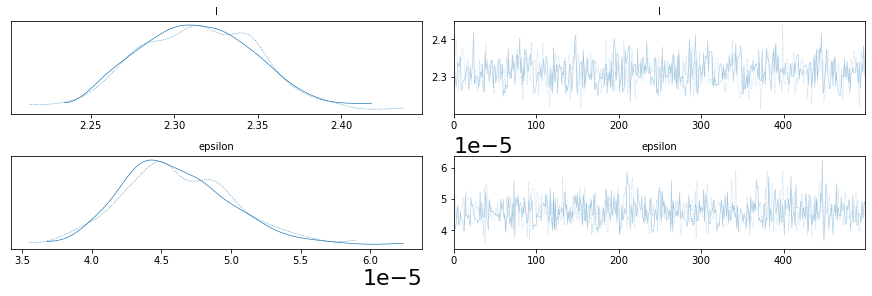

In [148]:
az.plot_trace(trace_reg)
#y_em_norm = model(torch.tensor(X_norm).to(torch.float)).mean.detach().numpy()
#y_em = y_em_norm * y_std + y_mean
_, ax = plt.subplots(figsize=(12,5))

point = {'l': trace_reg.posterior['l'].mean(), 'epsilon': trace_reg.posterior['epsilon'].mean()}

mu, var = gp.predict(X_train, point=point, diag=True)
y_em_pymc3 = mu*y_std + y_mean
y_train_real = y_train*y_std+y_mean
ax.plot( (y_em_pymc3 - y_train_real)/y_train_real , 'C1', marker='o')


In [91]:
trace_reg.posterior

<xarray.Dataset>
Dimensions:  (chain: 2, draw: 500)
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
Data variables:
    l        (chain, draw) float64 2.493 2.29 2.393 2.342 ... 2.416 2.425 2.373
    epsilon  (chain, draw) float64 0.0001337 0.0001111 ... 0.0001232 0.0001411
Attributes:
    created_at:                 2022-01-28T11:29:47.422094
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  3.11.2
    sampling_time:              13.085673570632935
    tuning_steps:               200

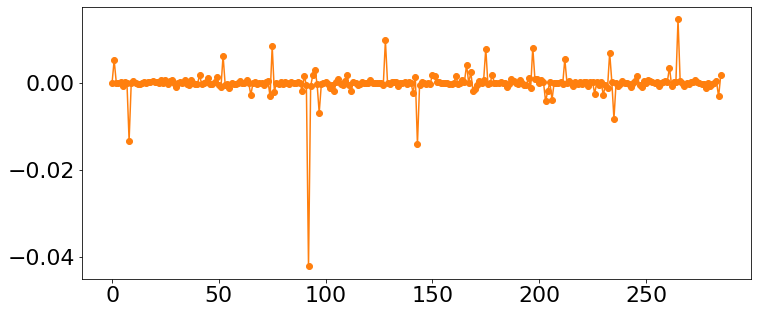

In [149]:
#y_em_norm = model(torch.tensor(X_norm).to(torch.float)).mean.detach().numpy()
#y_em = y_em_norm * y_std + y_mean
_, ax = plt.subplots(figsize=(12,5))

point = {'l': trace_reg.posterior['l'].mean(), 'epsilon': trace_reg.posterior['epsilon'].mean()}

mu, var = gp.predict(X_train, point=point, diag=True)
y_em_pymc3 = mu*y_std + y_mean
y_train_real = y_train*y_std+y_mean
ax.plot( (y_em_pymc3 - y_train_real)/y_train_real , 'C1', marker='o')


{'whiskers': [<matplotlib.lines.Line2D at 0x7f2800b5f730>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2800b5fe50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2800b5f310>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2800b675b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f27d0e33ac0>],
 'means': []}

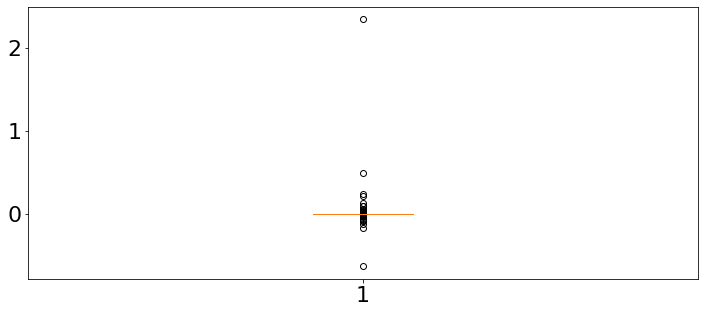

In [152]:
#y_em_norm = model(torch.tensor(X_norm).to(torch.float)).mean.detach().numpy()
#y_em = y_em_norm * y_std + y_mean
_, ax = plt.subplots(figsize=(12,5))

point = {'l': trace_reg.posterior['l'].mean(), 'epsilon': trace_reg.posterior['epsilon'].mean()}

mu, var = gp.predict(X_test, point=point, diag=True)
y_em_pymc3_test = mu*y_std + y_mean
y_test_real = y_test*y_std+y_mean
plt.boxplot( (y_em_pymc3_test - y_test_real)/y_test_real) #'C2', marker='o')


In [94]:
X_test[(y_em_pymc3_test - y_test_real)/ y_test_real > 0.05]*X_std +X_mean
# temp. bias, prcp. fac melt_f

array([[ 4.0e+00,  8.0e+00,  4.1e+02],
       [-5.0e+00,  1.0e-01,  1.0e+01],
       [-3.0e+00,  2.0e+00,  9.1e+02],
       [ 1.0e+00,  1.0e-01,  1.0e+01],
       [-3.0e+00,  1.5e+00,  7.1e+02],
       [ 4.0e+00,  4.0e+00,  2.1e+02],
       [ 0.0e+00,  1.0e-01,  1.0e+01],
       [-5.0e+00,  1.0e-01,  1.1e+02],
       [-2.0e+00,  1.0e-01,  1.0e+01],
       [-1.0e+00,  1.0e-01,  1.0e+01],
       [ 0.0e+00,  3.0e+00,  5.1e+02],
       [-1.0e+00,  5.0e-01,  1.1e+02],
       [-4.0e+00,  1.0e+00,  7.1e+02],
       [ 2.0e+00,  7.0e+00,  6.1e+02],
       [ 4.0e+00,  6.0e+00,  3.1e+02]])

Text(0, 0.5, 'Y (here: spec_mb)')

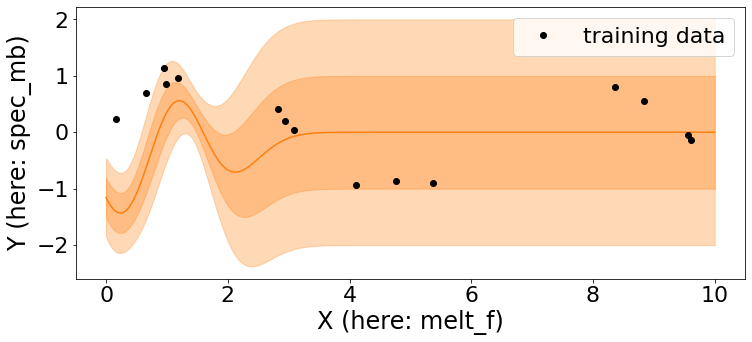

In [16]:


X_new = np.linspace(np.floor(X.min()), np.ceil(X.max()), 1000)[:,None]


# predict
mu, var = gp.predict(X_new, point=point, diag=True)
# mu, var = gp.predict(X_new, point=mp, diag=True)

sd = var**0.5


# plot the results
_, ax = plt.subplots(figsize=(12,5))
# plot mean and 1σ and 2σ intervals
ax.plot(X_new, mu, 'C1')
ax.fill_between(X_new.flatten(),
                 mu - sd, mu + sd,
                 color="C1",
                 alpha=0.3)

ax.fill_between(X_new.flatten(),
                 mu - 2*sd, mu + 2*sd,
                 color="C1",
                 alpha=0.3)

ax.plot(X, Y, 'ko', label= 'training data')
plt.legend()
ax.set_xlabel('X (here: melt_f)')
ax.set_ylabel('Y (here: spec_mb)')

In [11]:

with pm.Model() as model_reg:

    length_scale = pm.Gamma('length_scale', alpha=2, beta=1,
                            shape=(1, self.num_pred))
    signal_variance = pm.HalfCauchy('signal_variance', beta=5,
                                    shape=1)
    noise_variance = pm.HalfCauchy('noise_variance', beta=5,
                                   shape=1)

    cov_function = signal_variance ** 2 * RBF(
            input_dim=self.num_pred,
            ls=length_scale)

    if self.prior_mean is None:
        mean_function = pm.gp.mean.Zero()
    else:
        mean_function = self.prior_mean

    self.gp = pm.gp.Latent(mean_func=mean_function,
                           cov_func=cov_function)

    f = self.gp.prior('f', X=model_input.get_value())

    y = pm.Normal('y', mu=f, sd=noise_variance, observed=model_output)

NameError: name 'self' is not defined

In [114]:
class GaussianProcessRegressor_pymclearn(BayesianModel,
                               GaussianProcessRegressorMixin):
    """ Gaussian Process Regression built using PyMC3 (adapted from PyMC_learn).
    see: https://pymc-learn.readthedocs.io/en/latest/_modules/pmlearn/gaussian_process/gpr.html#GaussianProcessRegressor

    Fit a Gaussian process model and estimate model parameters using
    MCMC algorithms or Variational Inference algorithms

    Parameters
    ----------
    prior_mean : mean object
        The mean specifying the mean function of the GP. If None is passed,
        the mean "pm.gp.mean.Zero()" is used as default.

    kernel : covariance function (kernel)
        The function specifying the covariance of the GP. If None is passed,
        the kernel "RBF()" is used as default.

    Examples
    --------
    >>> from sklearn.datasets import make_friedman2
    >>> from pmlearn.gaussian_process import GaussianProcessRegressor
    >>> from pmlearn.gaussian_process.kernels import DotProduct, WhiteKernel
    >>> X, y = make_friedman2(n_samples=500, noise=0, random_state=0)
    >>> kernel = DotProduct() + WhiteKernel()
    >>> gpr = GaussianProcessRegressor(kernel=kernel).fit(X, y)
    >>> gpr.score(X, y) # doctest: +ELLIPSIS
    0.3680...
    >>> gpr.predict(X[:2,:], return_std=True) # doctest: +ELLIPSIS
    (array([653.0..., 592.1...]), array([316.6..., 316.6...]))


    Reference
    ----------
    Rasmussen and Williams (2006). Gaussian Processes for Machine Learning.
    """

    def __init__(self, prior_mean=None, kernel=None):
        self.ppc = None
        self.gp = None
        self.num_training_samples = None
        self.num_pred = None
        self.prior_mean = prior_mean
        self.kernel = kernel

        super(GaussianProcessRegressor_pymclearn, self).__init__()

    def create_model(self):
        """ Creates and returns the PyMC3 model.

        Note: The size of the shared variables must match the size of the
        training data. Otherwise, setting the shared variables later will
        raise an error. See http://docs.pymc.io/advanced_theano.html

        Returns
        ----------
        model: the PyMC3 model.
        """
        model_input = aet.shared(np.zeros([self.num_training_samples,
                                              self.num_pred]))

        model_output = aet.shared(np.zeros(self.num_training_samples))

        self.shared_vars = {
            'model_input': model_input,
            'model_output': model_output,
        }

        model = pm.Model()

        with model:
            length_scale = pm.Gamma('length_scale', alpha=2, beta=1,
                                    shape=(1, self.num_pred))
            signal_variance = pm.HalfCauchy('signal_variance', beta=5,
                                            shape=1)
            noise_variance = pm.HalfCauchy('noise_variance', beta=5,
                                           shape=1)

            if self.kernel is None:
                cov_function = signal_variance ** 2 * RBF(
                    input_dim=self.num_pred,
                    ls=length_scale)
            else:
                cov_function = self.kernel

            if self.prior_mean is None:
                mean_function = pm.gp.mean.Zero()
            else:
                mean_function = self.prior_mean

            self.gp = pm.gp.Latent(mean_func=mean_function,
                                   cov_func=cov_function)

            f = self.gp.prior('f', X=model_input.get_value())

            y = pm.Normal('y', mu=f, sd=noise_variance, observed=model_output)

        return model

    def save(self, file_prefix):
        params = {
            'inference_type': self.inference_type,
            'num_pred': self.num_pred,
            'num_training_samples': self.num_training_samples
        }

        super(GaussianProcessRegressor_pymclearn, self).save(file_prefix, params)


    def load(self, file_prefix):
        params = super(GaussianProcessRegressor_pymclearn, self).load(
            file_prefix, load_custom_params=True)

        self.inference_type = params['inference_type']
        self.num_pred = params['num_pred']
        self.num_training_samples = params['num_training_samples']

NameError: name 'BayesianModel' is not defined

### scikit-learn 2D

In [14]:
import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


In [15]:
X = pd_spec_mb[['melt_f','prcp_fac', 'temp_bias'] ].values
# test data
Y = pd_spec_mb['spec_mb_mean'].values
y = Y

In [16]:
# Instantiate a Gaussian Process model
#k1 = C(1.0, (1e-10, 1e10)) * RBF(10, (1e-10, 1e10))
# if we use the default settings, get the following error message:
# estimated length scale close to the length_scale bounds
k1 = C(1.0, (1e-5, 1e5)) * RBF(100, (1e-5, 1e5))
kernel = k1 #+ k2
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel = DotProduct() + DotProduct() +  WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

/home/lilianschuster/anaconda3/envs/pymc3_oggm/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


GaussianProcessRegressor(kernel=DotProduct(sigma_0=1) + DotProduct(sigma_0=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=9)

In [21]:


# Make the prediction on the meshed x-axis (ask for MSE as well)
#x = np.atleast_2d(np.linspace(10, 1000, 1000), np.linspace(0.1, 10, 1000)).T

arr = np.linspace(10, 1000, 100000) # 100000
np.random.shuffle(arr)

arr2 = np.linspace(0.1, 10, 100000)
np.random.shuffle(arr2)

arr3 = np.linspace(-10, 10, 100000)
np.random.shuffle(arr3)


x = np.array([arr, arr2, arr3]).T
#x = np.atleast_2d(np.linspace(10, 1000, 1000)) * np.atleast_2d(np.linspace(0.1, 10, 1000)).T
y_pred, sigma = gp.predict(x, return_std=True)

In [19]:
x[0]

array([665.77265773,   7.5498245 ,   0.90785908])

In [90]:
x_test

array([10. ,  0.1, -5. ])

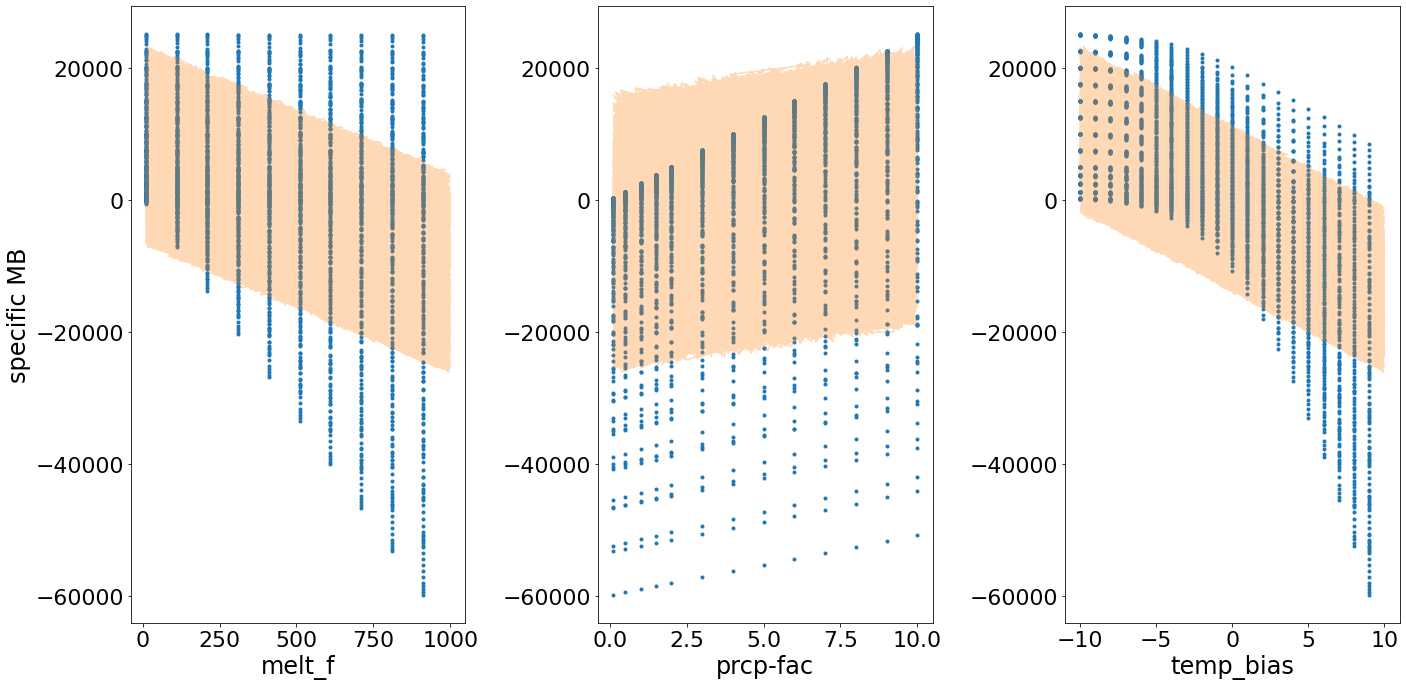

In [22]:
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.plot(X[:,0], y, '.')
plt.plot(x[:,0], y_pred, alpha =0.3);
plt.xlabel('melt_f')
plt.ylabel('specific MB')
plt.subplot(132)
plt.plot(X[:,1], y, '.')
plt.plot(x[:,1], y_pred, alpha =0.3);

plt.xlabel('prcp-fac')
plt.subplot(133)
plt.plot(X[:,2], y, '.')
plt.plot(x[:,2], y_pred, alpha =0.3);

plt.xlabel('temp_bias')
plt.tight_layout()

In [95]:
X[0]

array([10. ,  0.1, -5. ])

#### First: Check if we get the right values used for training  (this has to work by construction)

In [23]:
#plt.scatter(X, y, c='k')
#x_test = np.array([[10, 0.1, -5], [10, 0.1, 4]])
y_pred_train, sigma_train = gp.predict(X, return_std=True)

In [107]:
#y_pred_test, sigma_test = gp.predict(X, return_std=True)

In [109]:
Y

array([   218.86394854,    -16.22303801,   -251.31002457, ...,
        -8324.17786142, -11667.0421267 , -15009.90639197])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f1089376520>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1089435100>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1089376790>],
 'medians': [<matplotlib.lines.Line2D at 0x7f1089435820>],
 'fliers': [],
 'means': []}

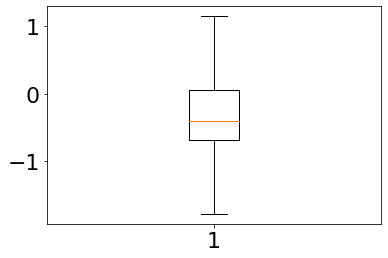

In [27]:
plt.boxplot((y_pred_train - Y)/Y, showfliers=False)

In [11]:
f = 0
a = f
a -= b
print(a)
f=100
print(a)

-100
-100


In [10]:
b

100

In [280]:
#sns.kdeplot
#(x=pd_spec_mb['melt_f'], y=pd_spec_mb['prcp_fac'], hue=pd_spec_mb['spec_mb']);

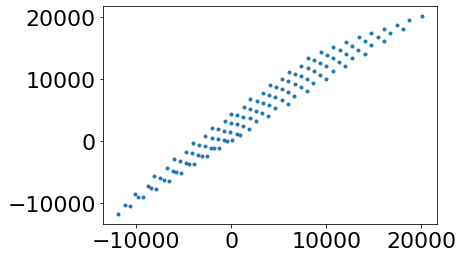

In [346]:
plt.plot(pd_spec_mb['spec_mb'], pd_spec_mb_sfc['spec_mb'], '.')

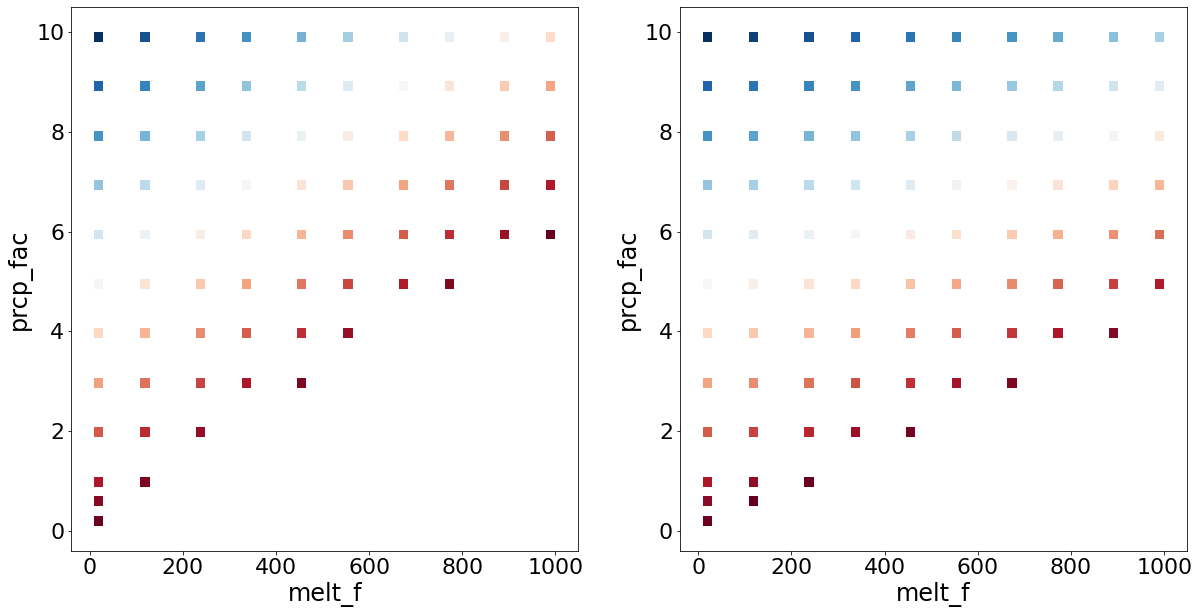

In [344]:
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.histplot(x=pd_spec_mb['melt_f'], y=pd_spec_mb['prcp_fac'], weights=pd_spec_mb['spec_mb'],
             bins=(50, 50), cmap='RdBu');

plt.subplot(122)
sns.histplot(x=pd_spec_mb_sfc['melt_f'], y=pd_spec_mb_sfc['prcp_fac'], weights=pd_spec_mb_sfc['spec_mb'],
             bins=(50, 50), cmap='RdBu');

In [10]:
pd_spec_mb_test = pd_spec_mb.where(pd_spec_mb.prcp_fac == 2).dropna()
X = pd_spec_mb_test['melt_f'].values
X=X.reshape(len(X), 1)
Y = pd_spec_mb_test['spec_mb'].values
y = Y

In [11]:
X

array([[  10.],
       [ 120.],
       [ 230.],
       [ 340.],
       [ 450.],
       [ 560.],
       [ 670.],
       [ 780.],
       [ 890.],
       [1000.]])

In [349]:
with pm.Model() as model_reg:
    # hyperprior for lengthscale kernel parameter ℓ = pm.Gamma('ℓ', 2, 0.5)
    l = pm.Gamma('l', 2, 0.01)
    # instantiate a covariance function 
    cov = pm.gp.cov.ExpQuad(1, ls=l)
    #cov = pm.gp.cov.Linear(1, ls=l)

    # instantiate a GP prior 
    gp = pm.gp.Marginal(cov_func=cov)
    # prior
    epsilon = pm.HalfNormal('epsilon', 25)
    # likelihood 
    y_pred = gp.marginal_likelihood('y_pred', X=X, y=Y, noise=epsilon)
    trace_reg = pm.sample(100, tune=100)
    mp = pm.find_MAP(include_transformed=True)


Only 100 samples in chain.
2021-10-04 13:39:11: pymc3: Only 100 samples in chain.
Auto-assigning NUTS sampler...
2021-10-04 13:39:11: pymc3: Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2021-10-04 13:39:11: pymc3: Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
2021-10-04 13:39:14: pymc3: Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, l]
2021-10-04 13:39:14: pymc3: NUTS: [epsilon, l]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 50 seconds.
2021-10-04 13:40:03: pymc3: Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 50 seconds.
The acceptance probability does not match the target. It is 0.9307312687387926, but should be close to 0.8. Try to increase the number of tuning steps.
2021-10-04 13:40:03: pymc3: The acceptance probability does not match the target. It is 0.9307312687387926, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9579885541235628, but should be close to 0.8. Try to increase the number of tuning steps.
2021-10-04 13:40:03: pymc3: The acceptance probability does not match the target. It is 0.9579885541235628, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.915009498932308, but should be close to 0.8. Try to in

## scikit-learn

In [351]:
# https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py

In [352]:
import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


### sciekit-learn 1D

In [111]:
# test data
pd_spec_mb_test = pd_spec_mb.where(pd_spec_mb.prcp_fac == 2).dropna()
pd_spec_mb_test = pd_spec_mb_test.where(pd_spec_mb_test.temp_bias == 0).dropna()

In [114]:
X = pd_spec_mb_test['melt_f'].values
X=X.reshape(len(X), 1)
Y = pd_spec_mb_test['spec_mb_mean'].values
y = Y

In [115]:
# Instantiate a Gaussian Process model

kernel = C(1.0, (1e-4, 1e4)) * RBF(10, (1e-3, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
x = np.atleast_2d(np.linspace(10, 1000, 1000)).T
y_pred, sigma = gp.predict(x, return_std=True)

/home/lilianschuster/anaconda3/envs/pymc3_oggm/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


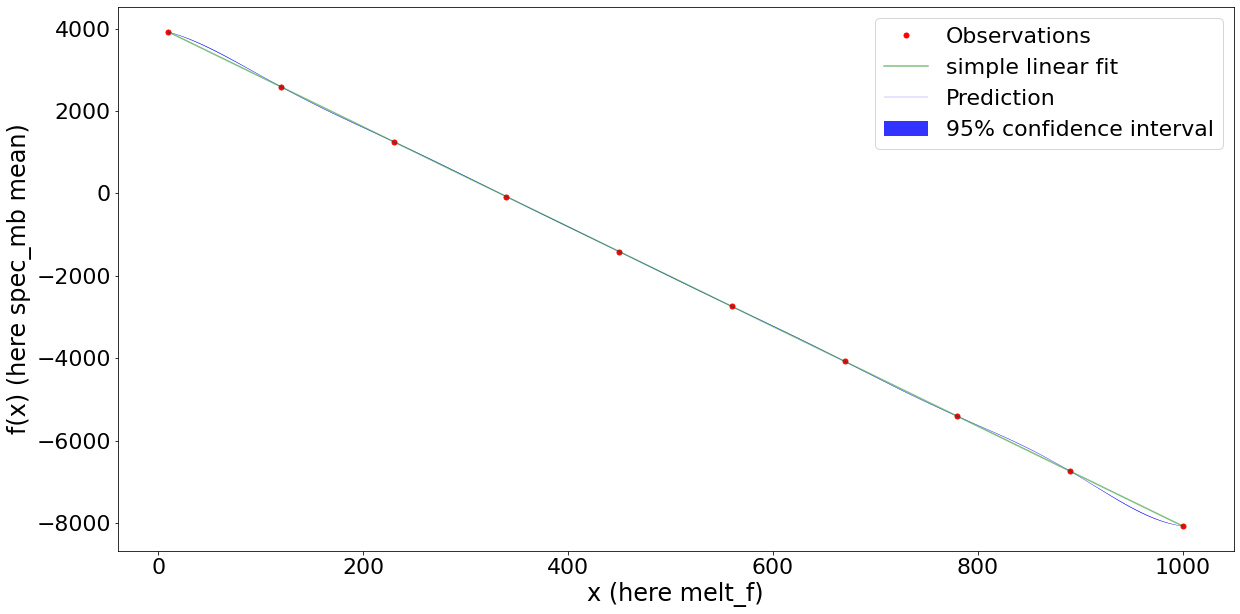

In [116]:
plt.figure(figsize=(20,10))
plt.plot(X, y, 'r.', markersize=10, label='Observations')
from sklearn.linear_model import LinearRegression
regr = LinearRegression().fit(X,y)
plt.plot(X, regr.predict(X), 'g-', markersize=10, label='simple linear fit', alpha = 0.5)

plt.plot(x, y_pred, 'b-', label='Prediction', lw = 0.2
        )
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.8, fc='blue', ec='None', label='95% confidence interval')
plt.xlabel('x (here melt_f)')
plt.ylabel('f(x) (here spec_mb mean)')
plt.legend()

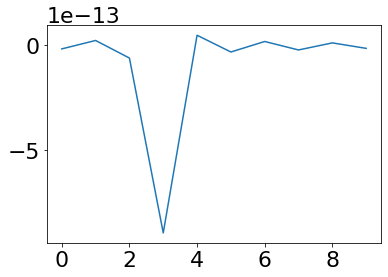

In [120]:
y_pred_train, sigma_train = gp.predict(X, return_std=True)

plt.plot((y_pred_train-y)/y)

same with sfc_type_distinction:

In [380]:
# test data
pd_spec_mb_test_sfc = pd_spec_mb_sfc.where(pd_spec_mb_sfc.prcp_fac == 2).dropna()
X = pd_spec_mb_test_sfc['melt_f'].values
X=X.reshape(len(X), 1)
Y = pd_spec_mb_test_sfc['spec_mb'].values
y = Y

In [381]:
# Instantiate a Gaussian Process model

kernel = C(1.0, (1e-4, 1e4)) * RBF(10, (1e-3, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
x = np.atleast_2d(np.linspace(10, 1000, 1000)).T
y_pred, sigma = gp.predict(x, return_std=True)

/home/lilianschuster/anaconda3/envs/pymc3_oggm/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


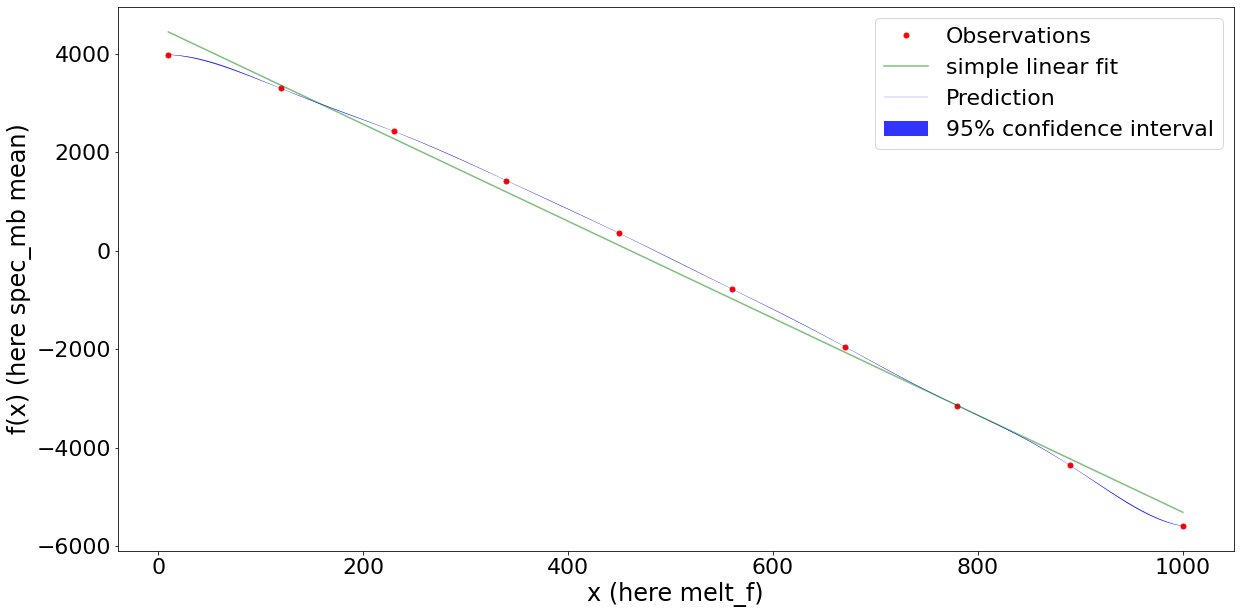

In [382]:
plt.figure(figsize=(20,10))
plt.plot(X, y, 'r.', markersize=10, label='Observations')
from sklearn.linear_model import LinearRegression
regr = LinearRegression().fit(X,y)
plt.plot(X, regr.predict(X), 'g-', markersize=10, label='simple linear fit', alpha = 0.5)

plt.plot(x, y_pred, 'b-', label='Prediction', lw = 0.2
        )
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.8, fc='blue', ec='None', label='95% confidence interval')
plt.xlabel('x (here melt_f)')
plt.ylabel('f(x) (here spec_mb mean)')
plt.legend()

### scikit-learn 2D

In [384]:
X = pd_spec_mb[['melt_f','prcp_fac'] ].values
# test data
Y = pd_spec_mb['spec_mb'].values
y = Y

In [398]:
# Instantiate a Gaussian Process model
#k1 = C(1.0, (1e-10, 1e10)) * RBF(10, (1e-10, 1e10))
# if we use the default settings, get the following error message:
# estimated length scale close to the length_scale bounds
k1 = C(1.0, (1e-4, 1e4)) * RBF(100, (1e-3, 1e3))
kernel = k1 #+ k2
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel = DotProduct() + DotProduct() +  WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
#x = np.atleast_2d(np.linspace(10, 1000, 1000), np.linspace(0.1, 10, 1000)).T

arr = np.linspace(10, 1000, 100000)
np.random.shuffle(arr)

arr2 = np.linspace(0.1, 10, 100000)
np.random.shuffle(arr2)


x = np.array([arr, arr2]).T
#x = np.atleast_2d(np.linspace(10, 1000, 1000)) * np.atleast_2d(np.linspace(0.1, 10, 1000)).T
y_pred, sigma = gp.predict(x, return_std=True)

/home/lilianschuster/anaconda3/envs/pymc3_oggm/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


In [395]:
pd_predi = pd.DataFrame([x[:,0], x[:,1], y_pred, sigma]).T
pd_predi.columns = ['melt_f', 'prcp_fac', 'mb_mean', 'sigma']

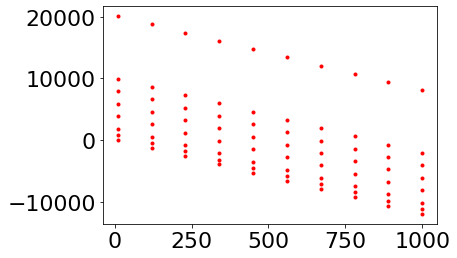

In [303]:
x[:,0]

array([907.02817028, 721.92601926, 280.31230312, ..., 705.95715957,
       631.18171182, 260.77940779])

In [302]:
np.absolute(y_pred)

array([2.62385810e-030, 2.82208206e-300, 2.72352937e-281, ...,
       4.09874107e-142, 3.08378982e-167, 1.07196019e-103])

In [298]:
pd_spec_mb[np.absolute(pd_spec_mb.spec_mb) <0.1]

,prcp_fac,melt_f,spec_mb


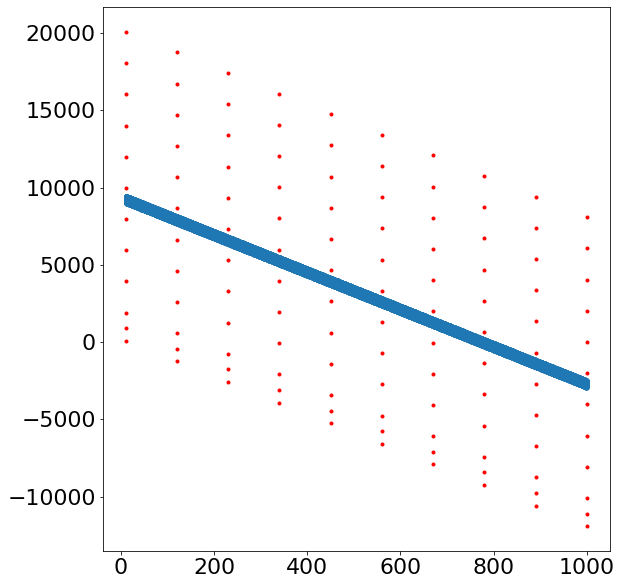

In [399]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(x[:,0], y_pred, '.')
plt.plot(pd_spec_mb.melt_f, pd_spec_mb.spec_mb, 'r.')


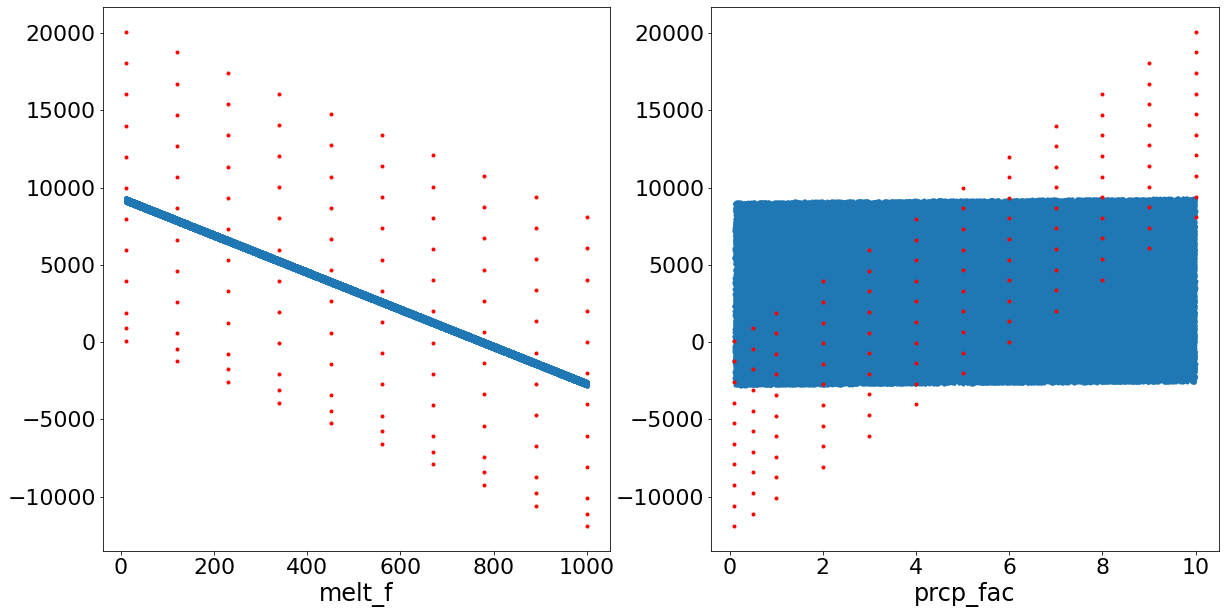

In [400]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(pd_predi.melt_f, pd_predi.mb_mean, '.')
plt.xlabel('melt_f')
plt.plot(pd_spec_mb.melt_f, pd_spec_mb.spec_mb, 'r.')
plt.subplot(122)
plt.plot(pd_predi.prcp_fac, pd_predi.mb_mean, '.')
plt.xlabel('prcp_fac')
plt.plot(pd_spec_mb.prcp_fac, pd_spec_mb.spec_mb, 'r.')

In [ ]:
sns.histplot(x=pd_predi['melt_f'], y=pd_predi['prcp_fac'], weights=pd_predi['mb_mean'],
             bins=(40, 40), cmap='RdBu')

In [204]:
pd_predi =pd_predi.pivot('melt_f', 'prcp_fac', 'mb_mean')

# some example gp implementations with sklearn

Automatically created module for IPython interactive environment
GPML kernel: 66**2 * RBF(length_scale=67) + 2.4**2 * RBF(length_scale=90) * ExpSineSquared(length_scale=1.3, periodicity=1) + 0.66**2 * RationalQuadratic(alpha=0.78, length_scale=1.2) + 0.18**2 * RBF(length_scale=0.134) + WhiteKernel(noise_level=0.0361)
Log-marginal-likelihood: 155.006

Learned kernel: 2.62**2 * RBF(length_scale=51.6) + 0.155**2 * RBF(length_scale=91.5) * ExpSineSquared(length_scale=1.49, periodicity=1) + 0.0315**2 * RationalQuadratic(alpha=2.87, length_scale=0.968) + 0.011**2 * RBF(length_scale=0.122) + WhiteKernel(noise_level=0.000126)
Log-marginal-likelihood: 1362.655


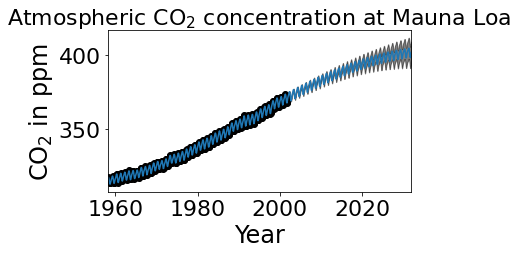

In [67]:
# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#
# License: BSD 3 clause


import numpy as np

from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

print(__doc__)


def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187, as_frame=False)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs


X, y = load_mauna_loa_atmospheric_co2()

# Kernel with parameters given in GPML book
k1 = 66.0**2 * RBF(length_scale=67.0)  # long term smooth rising trend
k2 = 2.4**2 * RBF(length_scale=90.0) \
    * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # seasonal component
# medium term irregularity
k3 = 0.66**2 \
    * RationalQuadratic(length_scale=1.2, alpha=0.78)
k4 = 0.18**2 * RBF(length_scale=0.134) \
    + WhiteKernel(noise_level=0.19**2)  # noise terms
kernel_gpml = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel_gpml, alpha=0,
                              optimizer=None, normalize_y=True)
gp.fit(X, y)

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

# Kernel with optimized parameters
k1 = 50.0**2 * RBF(length_scale=50.0)  # long term smooth rising trend
k2 = 2.0**2 * RBF(length_scale=100.0) \
    * ExpSineSquared(length_scale=1.0, periodicity=1.0,
                     periodicity_bounds="fixed")  # seasonal component
# medium term irregularities
k3 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-5, np.inf))  # noise terms
kernel = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel, alpha=0,
                              normalize_y=True)
gp.fit(X, y)

print("\nLearned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

X_ = np.linspace(X.min(), X.max() + 30, 1000)[:, np.newaxis]
y_pred, y_std = gp.predict(X_, return_std=True)

# Illustration
plt.scatter(X, y, c='k')
plt.plot(X_, y_pred)
plt.fill_between(X_[:, 0], y_pred - y_std, y_pred + y_std,
                 alpha=0.5, color='k')
plt.xlim(X_.min(), X_.max())
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
plt.show()